# Description

In this notebook we will generate the figures used in the experiment. For this we will superimpose several prototype MCG signals with different kind of noise.

# Imports

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt 
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import scipy.signal as signal
from damnedlib.signal.prototype import Prototype
import damnedlib.filter.iir.visualization as vis
from damnedlib.utils.figures import save_fig
from damnedlib.signal.analyze import generate_noise
import damnedlib.signal.metrics as metrics
import os

import damnedlib.utils.jupyter_settings


# Settings

In [2]:
save_png = False
save_tikz = False
save_pdf = False
prefix = ""
img_dir = f"../figures/"
data_dir = f"../data/"

if not os.path.exists(img_dir):
    os.makedirs(img_dir)
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

T = 5
fs = 3200
fs_low = 200
ts = 1 / fs
ts_low = 1 / fs_low
numtaps = 255

nfft = int(fs)
nperseg= int(fs)

np.random.seed(42)

# Calculations

## Filter Function

In [3]:
def filter_signal(y, plot_filter=False, save_filter=False):
    # decimate signal by 16
    y_dec = y
    y_dec = signal.decimate(y_dec, 4)
    y_dec = signal.decimate(y_dec, 4)

    mean = np.mean(y_dec)

    # apply bandstop filter (50 Hz)
    numtaps = 199
    bands = np.array((0, 48, 49, 51, 52, fs_low/2))
    stop = 1e-6
    desired = np.array((1, 1, stop, stop, 1, 1))

    b = signal.firls(numtaps, bands, desired, fs=fs_low)
    y_bp = signal.lfilter(b=b, a=1, x=np.pad(y_dec, [0, numtaps//2]))[numtaps//2:]
    
    if plot_filter:
        fig, axs = vis.plot_filter_response(b, fs=fs_low, save=save_filter,
            title='Bandstop Filter Response',
            file_name="bandstop_filter",
            dir = img_dir,
            )

    # apply highpass filter (1 Hz)
    numtaps = 599
    bands = np.array((0, 0.5, 1, fs_low/2))
    stop = 1e-6
    desired = np.array((stop, stop, 1, 1))

    b = signal.firls(numtaps, bands, desired, fs=fs_low)
    y_hp = signal.lfilter(b=b, a=1, x=np.pad(y_bp, [0, numtaps//2]))[numtaps//2:]
    
    if plot_filter:
        fig, axs = vis.plot_filter_response(b, fs=fs_low, save=save_filter,
            title='Highpass Filter Response',
            file_name='Highpass_filter',
            dir = img_dir,
            )
    
    return y_hp + mean

## Signal Generation

### Definition

In [4]:
t = np.arange(0, T, ts)
t_low = np.arange(0, T, ts_low)
t_ms = t * 1000
t_low_ms = t_low * 1000
ylim_time = [-100, 100]
ylim_psd = [1e-12, 1e2]
xlim_psd = [0, 200]

mcg = Prototype.MCG()
mcg_y = mcg(t)
f, mcg_Syy = metrics.psd_from_time(y=mcg_y, fs=fs, nfft=nfft)
mcg_power = metrics.power_from_psd(Syy=mcg_Syy, fs=fs, nfft=nfft)

mcg_awi = Prototype.MCG_AWI()
mcg_awi_y = mcg_awi(t)
f, mcg_awi_Syy = metrics.psd_from_time(y=mcg_awi_y, fs=fs, nfft=nfft)
mcg_awi_power = metrics.power_from_psd(Syy=mcg_awi_Syy, fs=fs, nfft=nfft)

mcg_lbbb = Prototype.MCG_LBBB()
mcg_lbbb_y = mcg_lbbb(t)
f, mcg_lbbb_Syy = metrics.psd_from_time(y=mcg_lbbb_y, fs=fs, nfft=nfft)
mcg_lbbb_power = metrics.power_from_psd(Syy=mcg_lbbb_Syy, fs=fs, nfft=nfft)

mcg_af = Prototype.MCG_AF()
mcg_af_y = mcg_af(t)
f, mcg_af_Syy = metrics.psd_from_time(y=mcg_af_y, fs=fs, nfft=nfft)
mcg_af_power = metrics.power_from_psd(Syy=mcg_af_Syy, fs=fs, nfft=nfft)

mcg_lqt = Prototype.MCG_LQT()
mcg_lqt_y = mcg_lqt(t)
f, mcg_lqt_Syy = metrics.psd_from_time(y=mcg_lqt_y, fs=fs, nfft=nfft)
mcg_lqt_power = metrics.power_from_psd(Syy=mcg_lqt_Syy, fs=fs, nfft=nfft)

# mcg_hk = Prototype.MCG_HK()
# mcg_hk_y = mcg_hk(t)
# f, mcg_hk_Syy = metrics.psd_from_time(y=mcg_hk_y, fs=fs, nfft=nfft)
# mcg_hk_power = metrics.power_from_psd(Syy=mcg_hk_Syy, fs=fs, nfft=nfft)

signals_y = [mcg_y, mcg_awi_y, mcg_lbbb_y, mcg_af_y, mcg_lqt_y] #, mcg_hk_y]
names = [
    "Healthy MCG Signal (Lead: I)",
    "Anterior Wall Infarction MCG Signal (Lead V3)",
    "Left Bundle Branch Block MCG Signal (Lead V6)",
    "Atrial Fibrillation MCG Signal (Lead III)",
    "Long-QT Syndrome MCG Signal (Lead I)",
    # "Hyperkalaemia MCG Signal (Lead V3)",
]

### Plot

In [5]:
def plot_signals(noise_y=None, plot_filter=False, file_affix="", file_prefix=""):
    plt.rc("figure", figsize=(8, 3.5), max_open_warning=0, dpi=200, autolayout=True)
    plt.rc("lines", linewidth=0.75)
    
    snr_dict = dict()
    asc_dict = dict()
    
    if noise_y is None:
        noise_y = np.zeros_like(mcg_y)

    f, noise_Syy = metrics.psd_from_time(y=noise_y, fs=fs, nfft=nfft)
    noise_power = metrics.power_from_psd(Syy=noise_Syy, fs=fs, nfft=nfft)

    for i in range(len(signals_y)):
        f, signal_Syy = metrics.psd_from_time(y=signals_y[i], fs=fs, nfft=nfft)
        signal_power = metrics.power_from_psd(Syy=signal_Syy, fs=fs, nfft=nfft)
        
        if noise_power > 0.0:
            snr = signal_power/noise_power
            asc = metrics.asc_from_psd(Syy_signal=signal_Syy,
                                    Syy_noise=noise_Syy,
                                    fs=fs,
                                    nfft=nfft)
            snr_dict[f"{file_prefix}{i}"] = snr
            asc_dict[f"{file_prefix}{i}"] = asc

        fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)
        fig.suptitle(names[i])
        ax[0].plot(t, signals_y[i])
        ax[0].set_ylim(ylim_time)
        ax[1].plot(t_low, filter_signal(signals_y[i] + noise_y, plot_filter= ((i==0) and plot_filter)))
        ax[1].set_ylim(ylim_time)
        ax[0].set_ylabel("Ideal\nSignal\n[pT]", rotation="horizontal", va="center", ha="right")
        ax[1].set_ylabel("Measured\nSignal\n[pT]", rotation="horizontal", va="center", ha="right")

        ax[0].xaxis.set_major_locator(MultipleLocator(0.2))
        ax[0].xaxis.set_minor_locator(AutoMinorLocator(5))
        for n, label in enumerate(ax[0].xaxis.get_ticklabels()):
            if n % 5 != 1:
                label.set_visible(False)

        ax[1].xaxis.set_major_locator(MultipleLocator(0.2))
        ax[1].xaxis.set_minor_locator(AutoMinorLocator(5))
        for n, label in enumerate(ax[1].xaxis.get_ticklabels()):
            if n % 5 != 1:
                label.set_visible(False)

        ax[0].yaxis.set_major_locator(MultipleLocator(50))
        ax[0].yaxis.set_minor_locator(AutoMinorLocator(5))
        for n, label in enumerate(ax[0].yaxis.get_ticklabels()):
            if n % 2 != 1:
                label.set_visible(False)

        ax[1].yaxis.set_major_locator(MultipleLocator(50))
        ax[1].yaxis.set_minor_locator(AutoMinorLocator(5))
        for n, label in enumerate(ax[1].yaxis.get_ticklabels()):
            if n % 2 != 1:
                label.set_visible(False)

        ax[0].grid(which="major", color="#888888", linestyle='-')
        ax[0].grid(which="minor", color="#BBBBBB", linestyle='-', alpha=0.5)
        ax[1].grid(which="major", color="#888888", linestyle='-')
        ax[1].grid(which="minor", color="#BBBBBB", linestyle='-', alpha=0.5)

        ax[1].set_xlabel("$t$ [s]")
        plt.tight_layout()
    
        save_fig(fig, filename=f"{img_dir}/{file_prefix}{i}_signals{file_affix}", save_png=save_png, save_tikz=False)
    
    return snr_dict, asc_dict

({}, {})

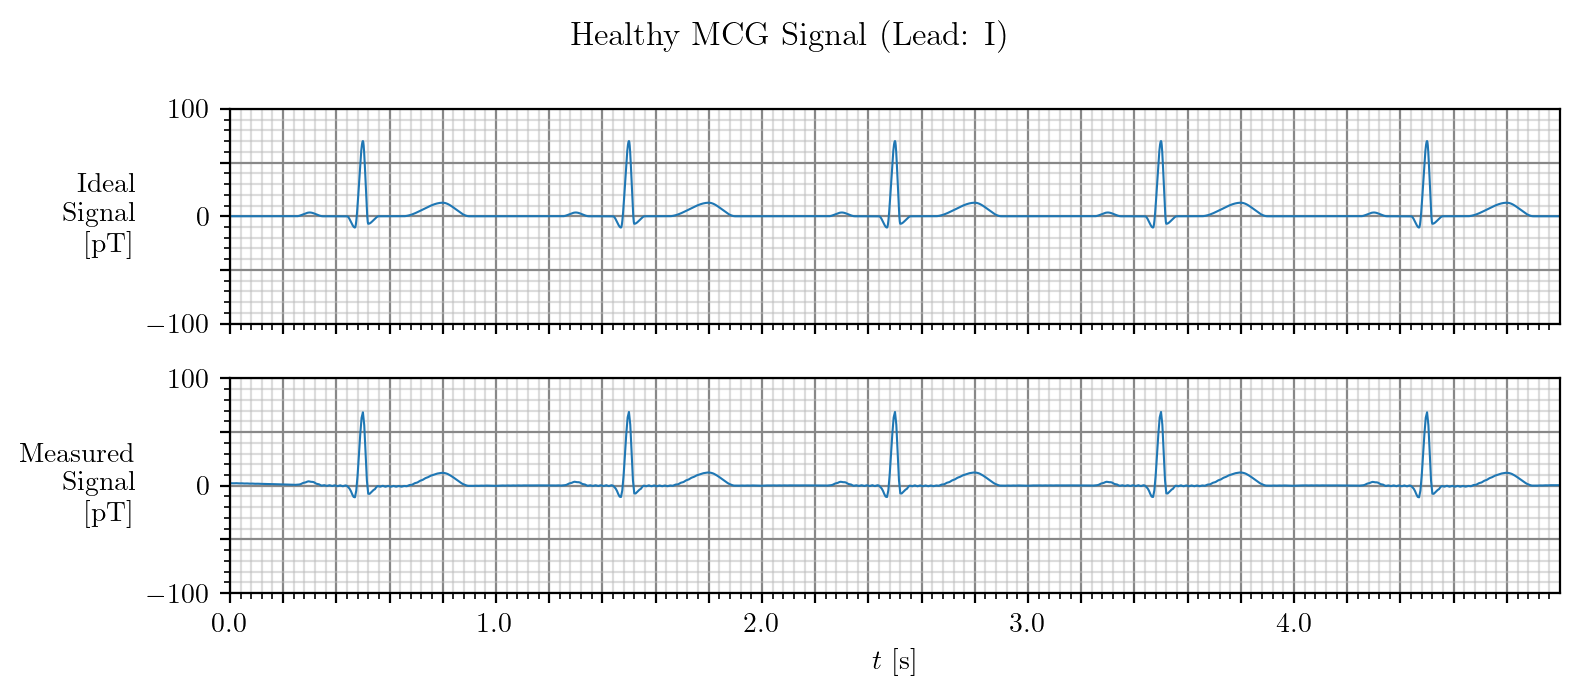

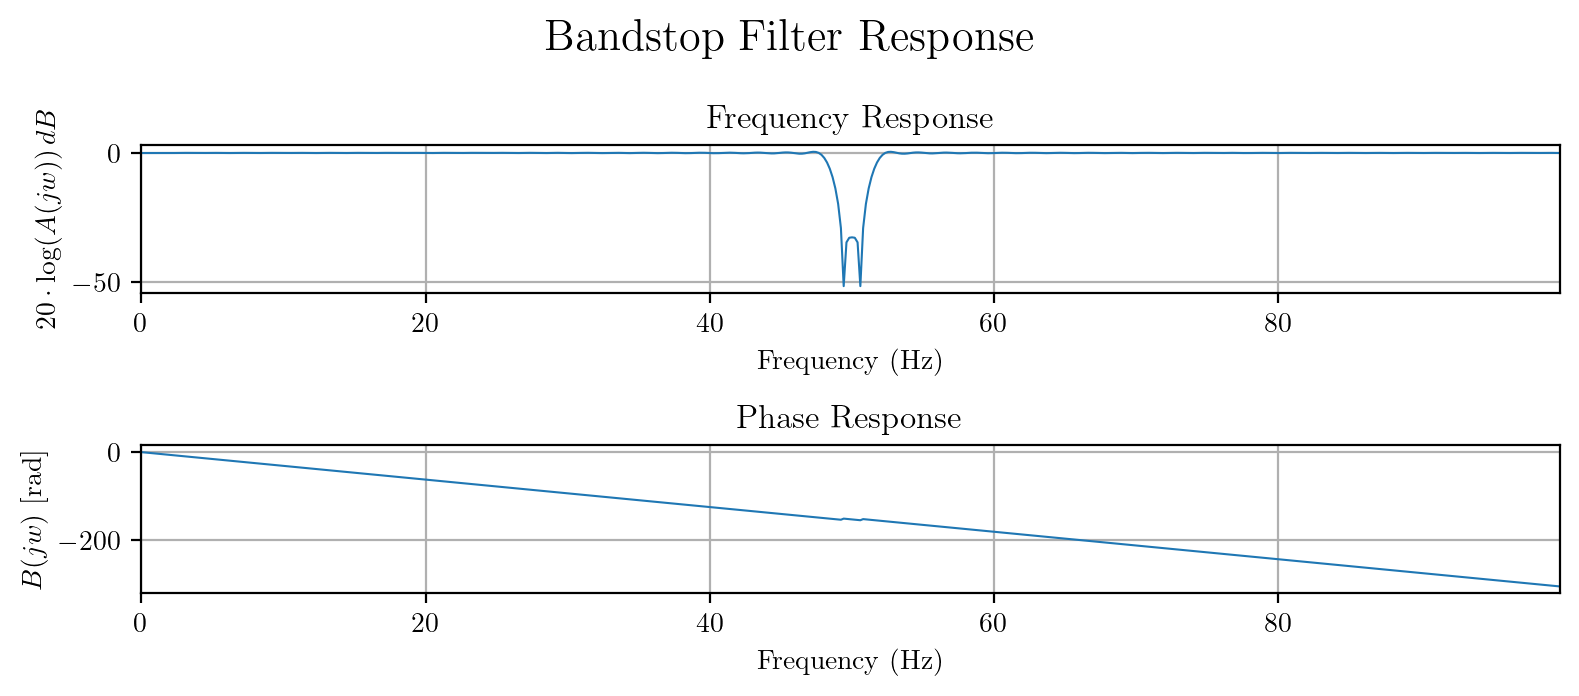

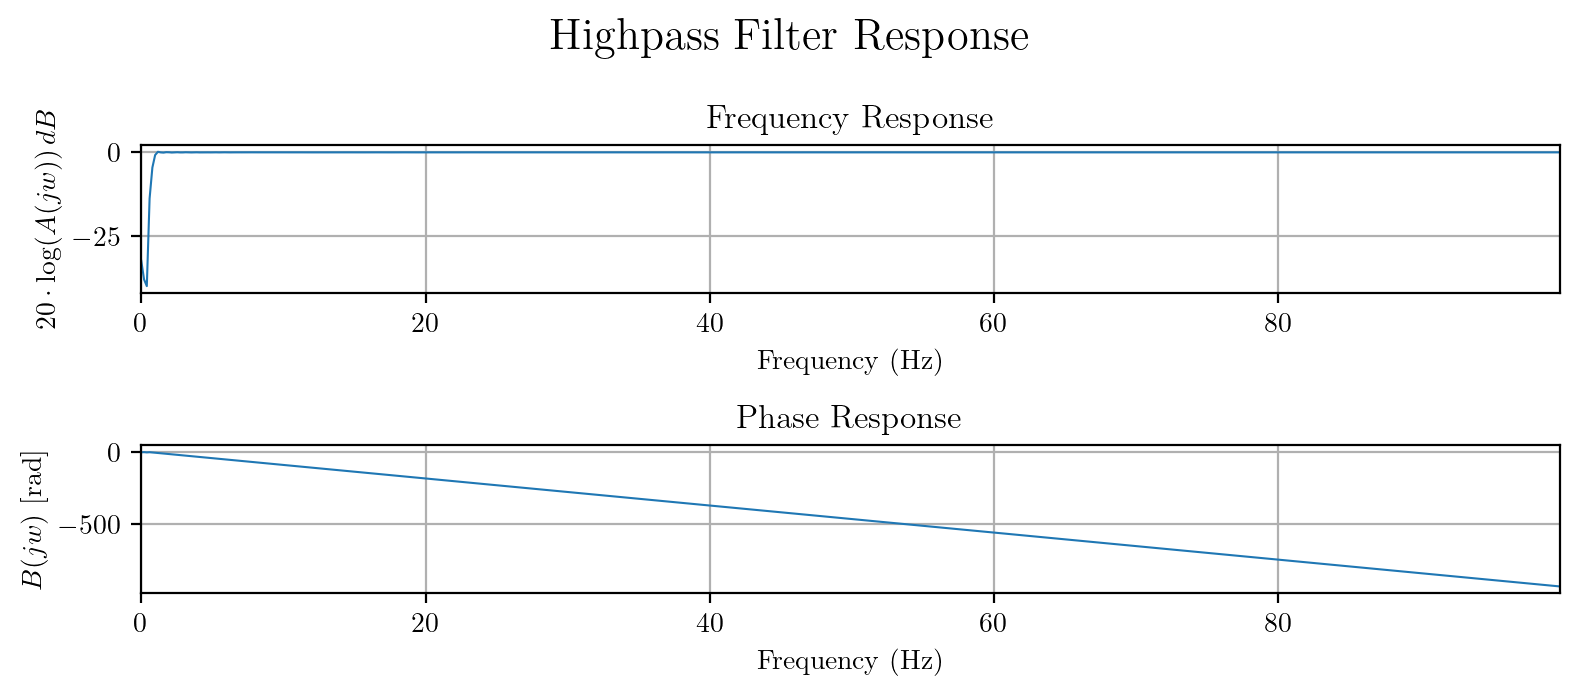

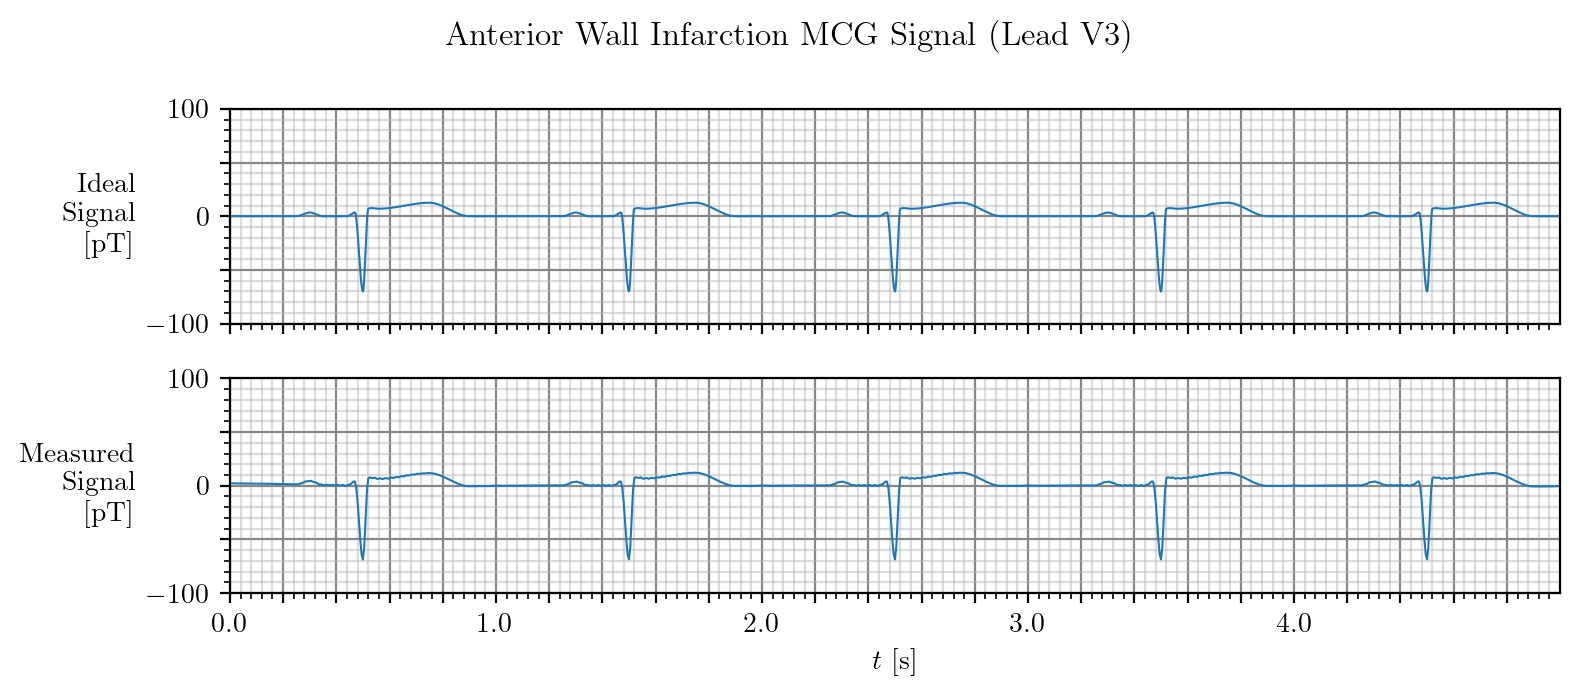

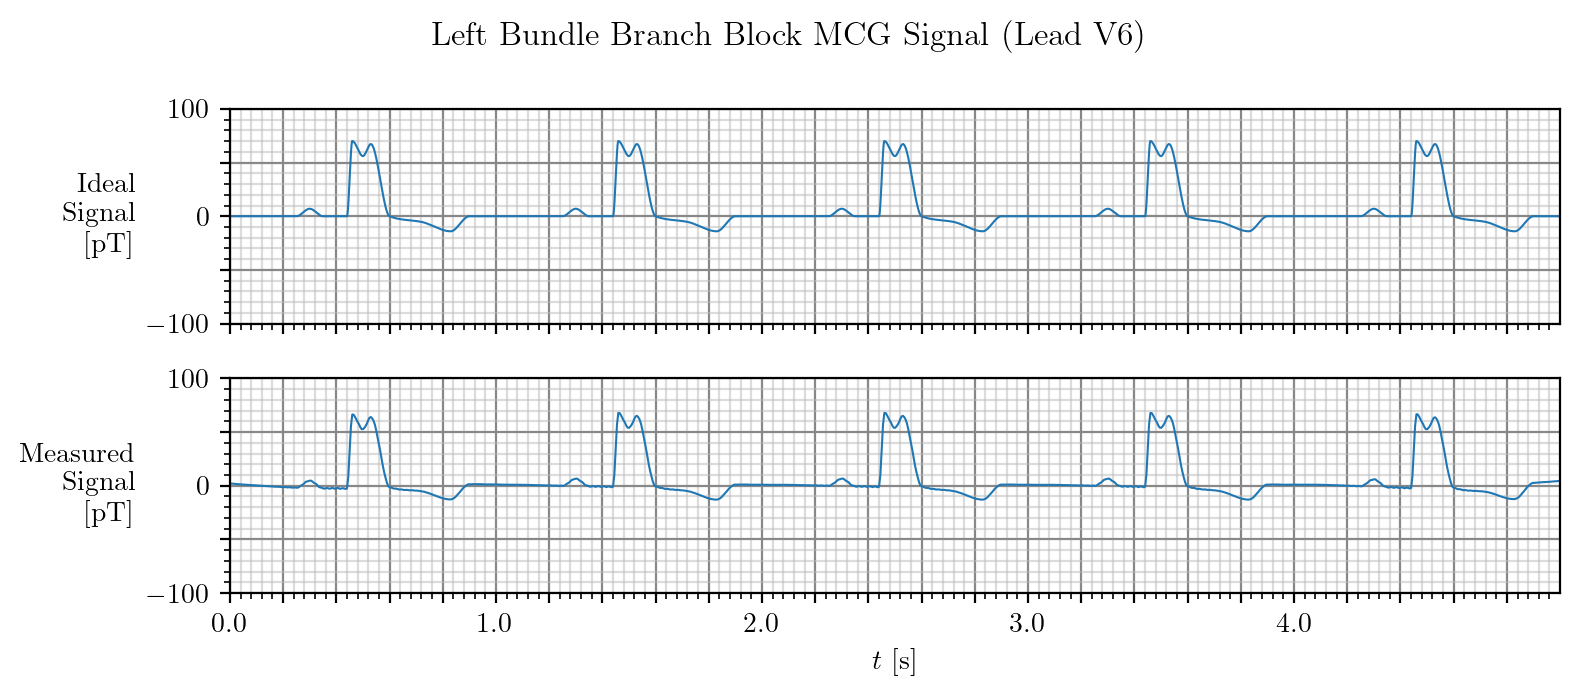

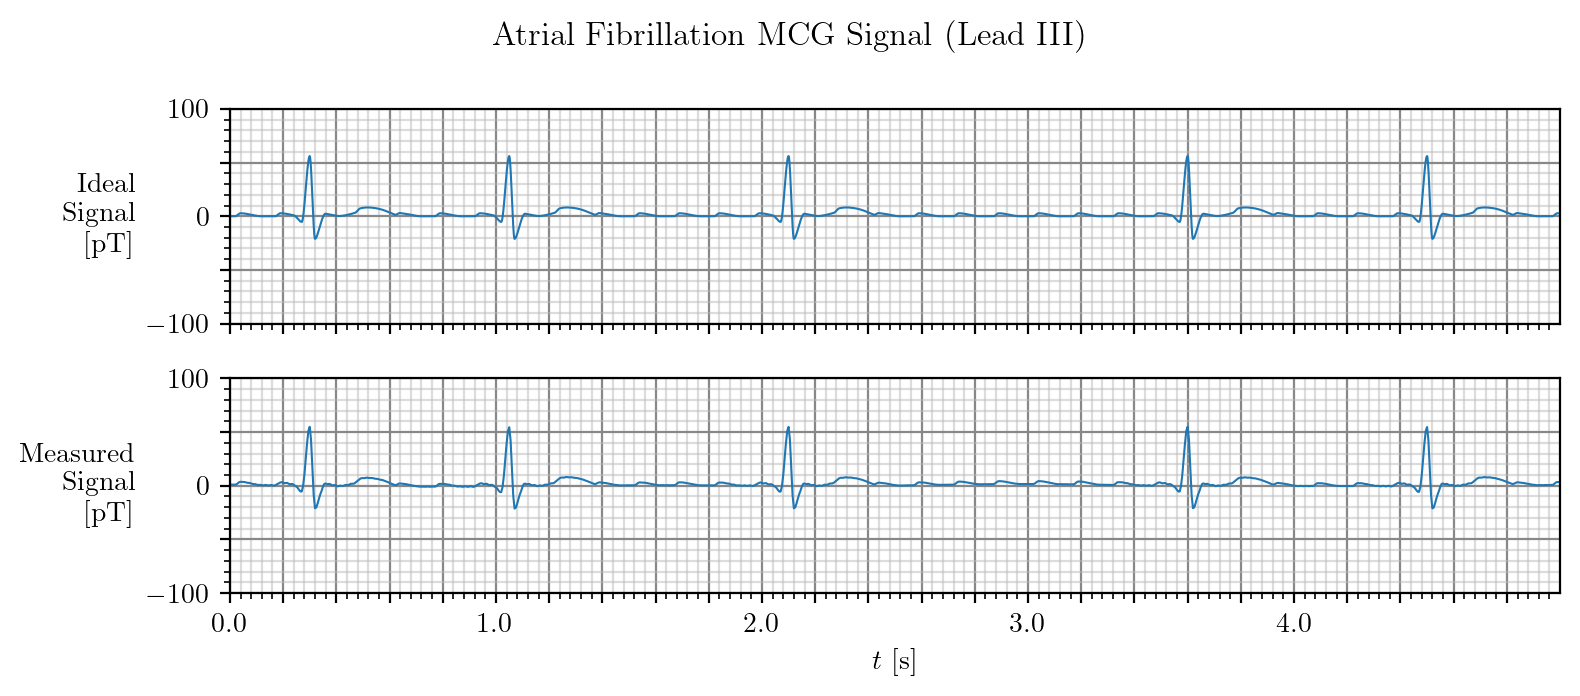

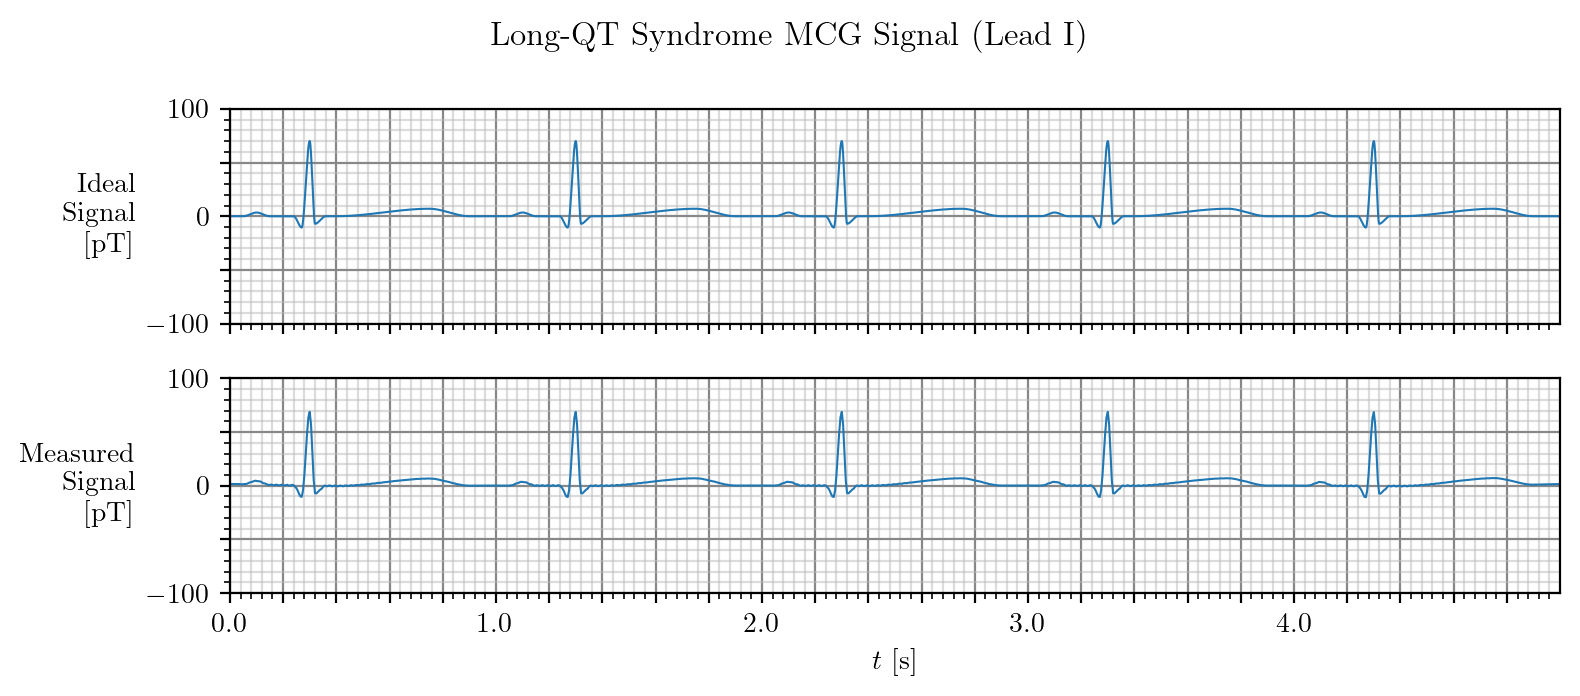

In [6]:
plot_signals(plot_filter=True, file_prefix="0_")

## Noise Generation

In [7]:
plt.rc("figure", figsize=(8, 4.5), max_open_warning=0, dpi=200, autolayout=True)
plt.rc("lines", linewidth=1.5)

### Noise Shape

In [8]:
noise_bands = np.linspace(0, fs/2, int(fs/2))
noise_gain = 1/(noise_bands+1)+0.01

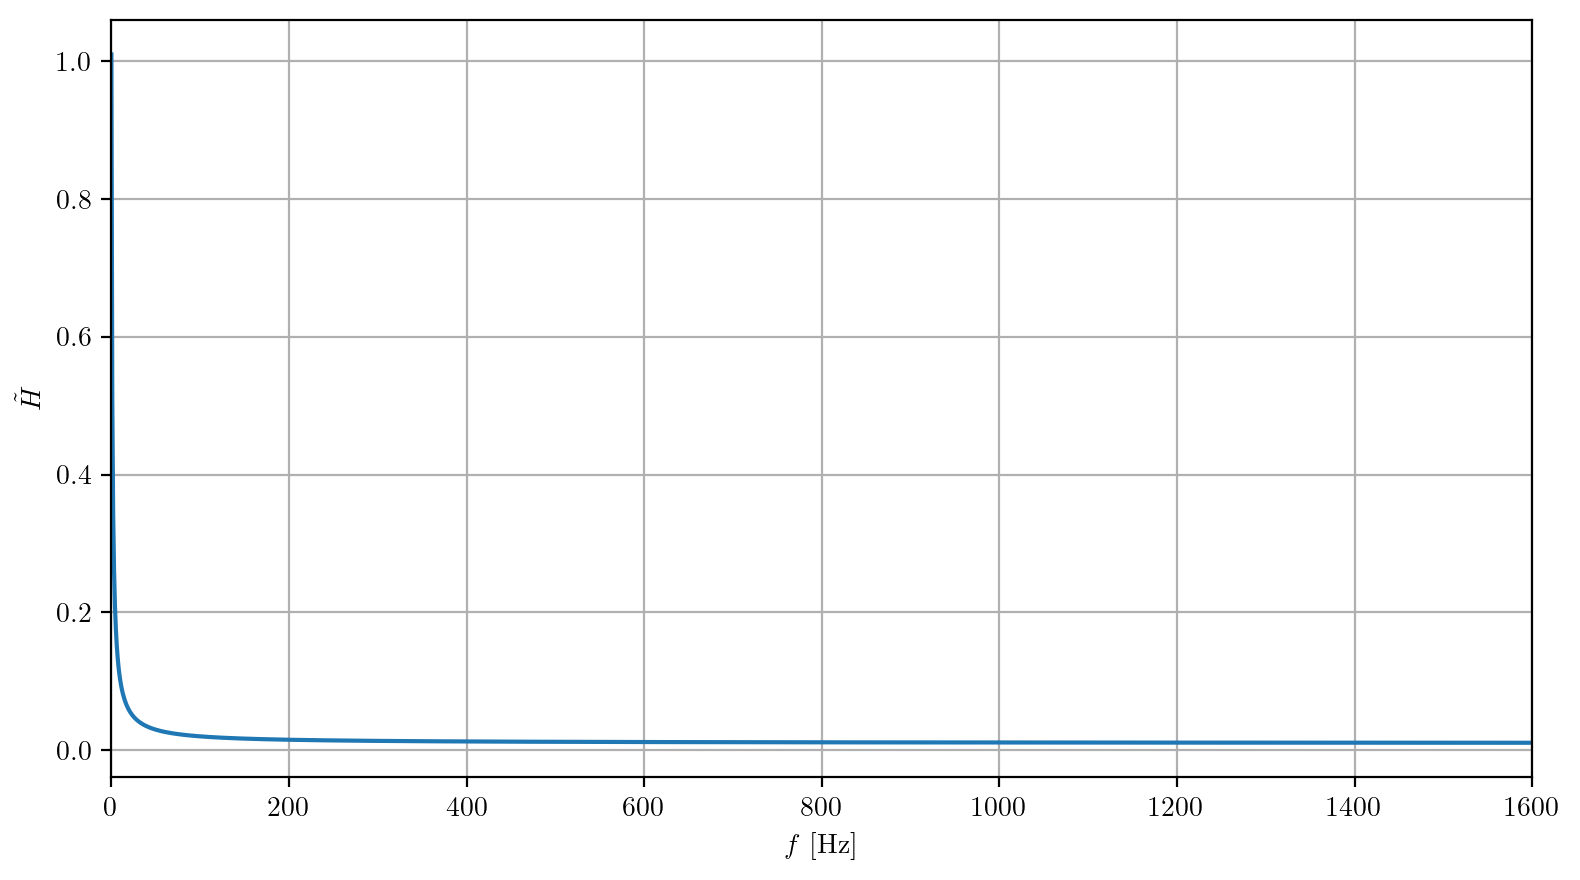

In [9]:
fig, ax = plt.subplots()
ax.set_xlabel("$f$ [Hz]")
ax.set_ylabel("$\\tilde{H}$")
ax.plot(noise_bands, noise_gain, label="$1/f$")

### Generation

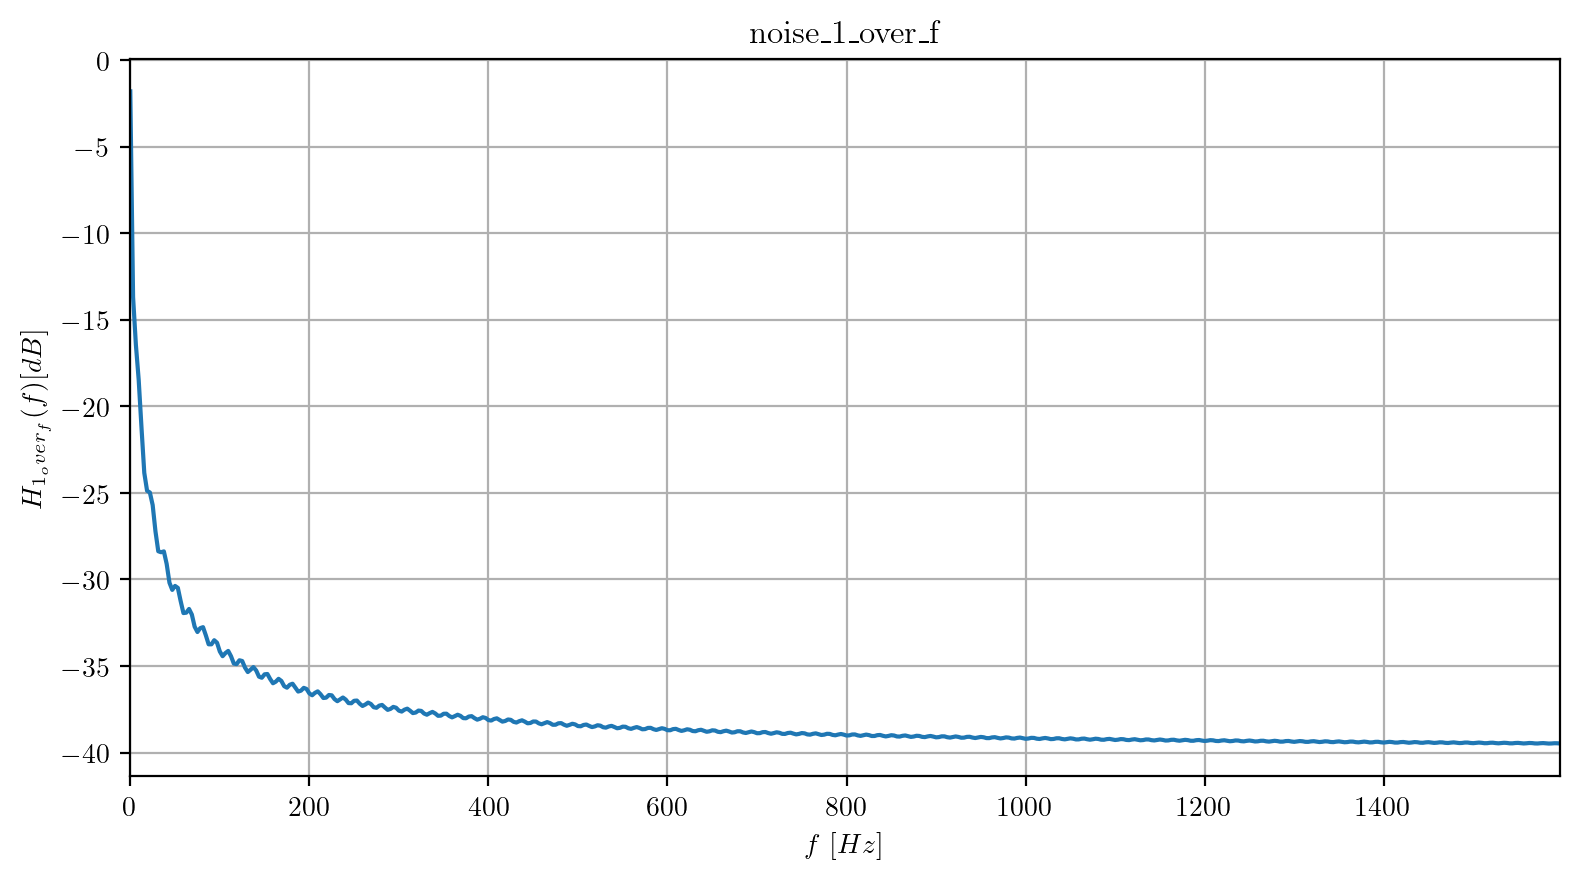

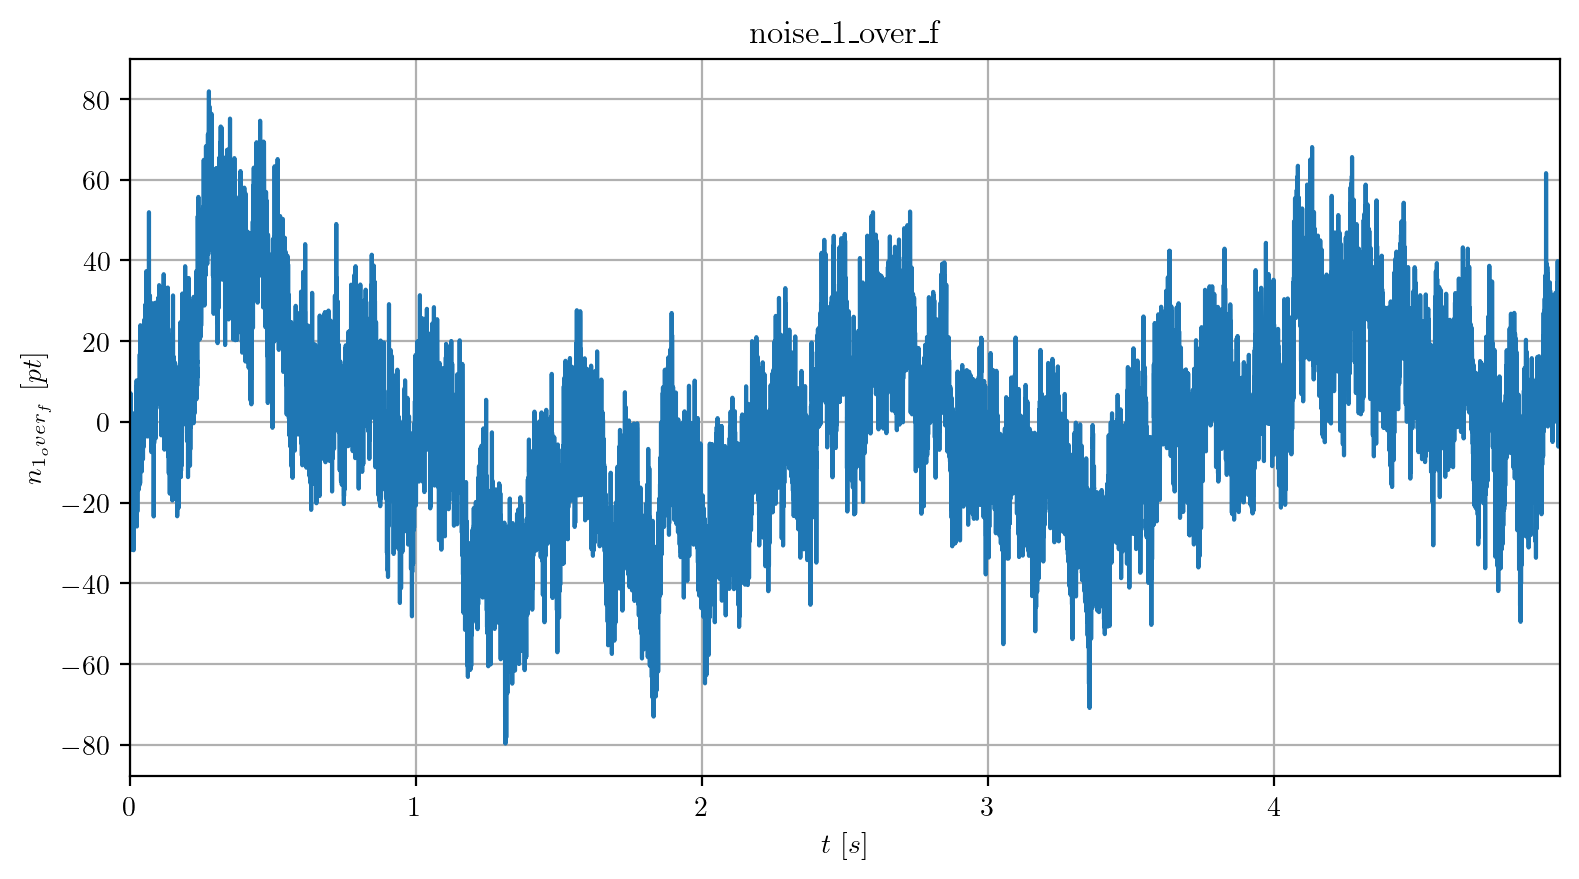

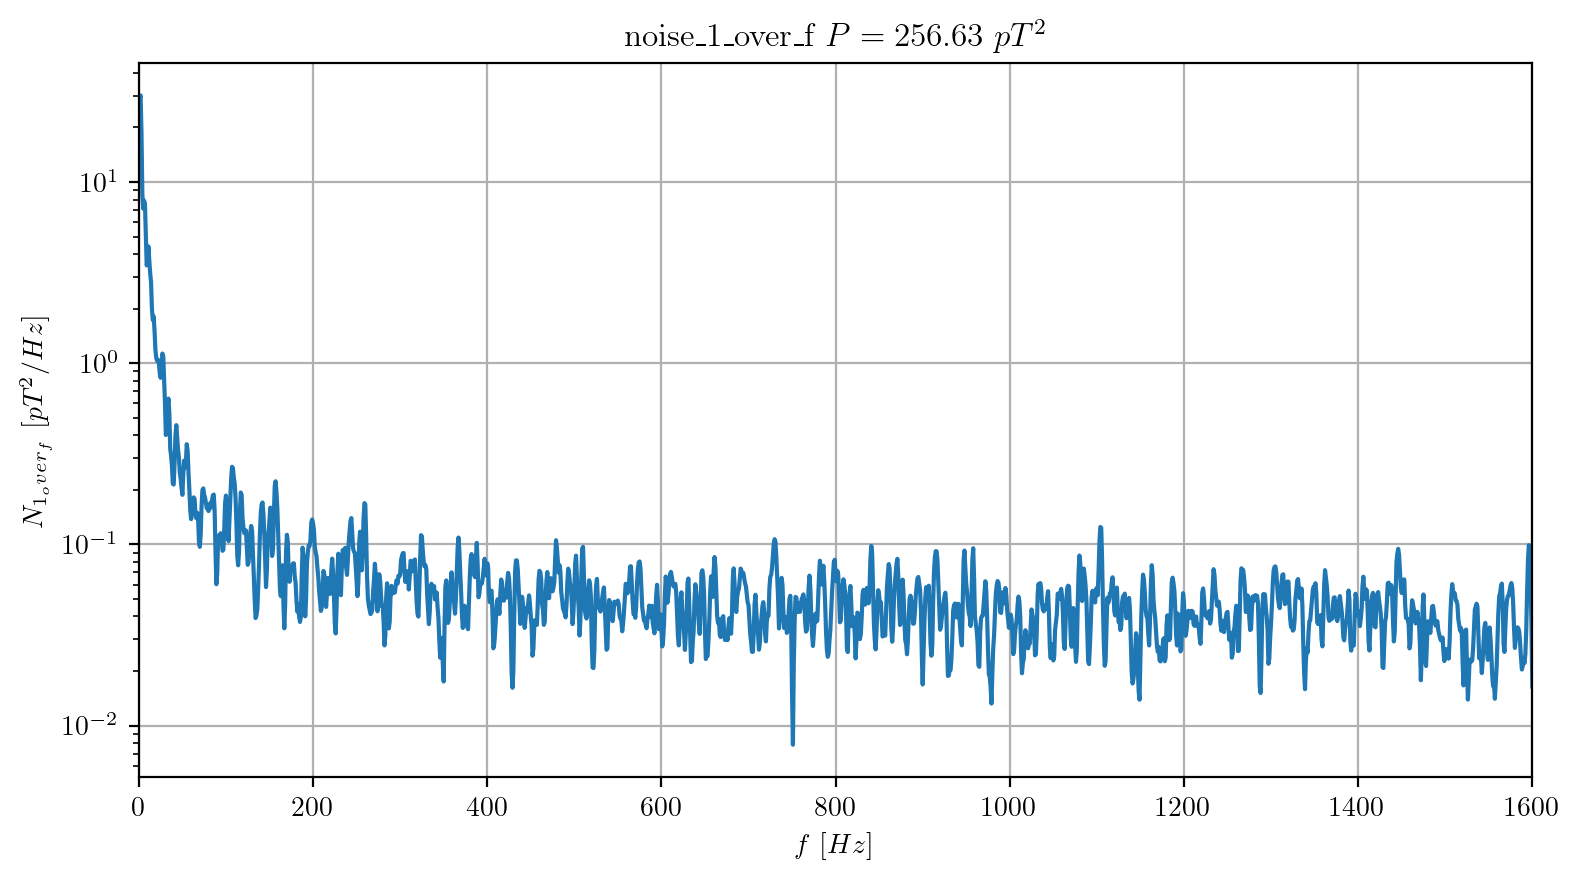

In [10]:
np.random.seed(42)
noise_y, noise_Syy, noise_power = generate_noise(
    bands=noise_bands,
    gain=noise_gain,
    name="1_over_f",
    power_signal=mcg_power,
    snr_desired=1,
    fs=fs,
    T=T,
    nfft=nfft,
    file_prefix=img_dir,
    file_affix=f"snr_desired_{1}",
    save_png=save_png,
    save_tikz=False,
    generate_figures=True,
    f=f,
    t=t,
    numtaps=int(fs/2)-1,
)

### Amplitude

In [11]:
snr_desired_db = [
    -5,
    #-3.75,
    #-2.5,
    #-1.25,
    0,
    #1.25,
    #2.5,
    #3.75,
    5,
    #7.5,
    10,
    #12.5,
    15,
    20,
    30,
]

snr_desired = [10**(x/10) for x in snr_desired_db]

print(snr_desired)

[0.31622776601683794, 1.0, 3.1622776601683795, 10.0, 31.622776601683793, 100.0, 1000.0]


## Noisy Signal Generation

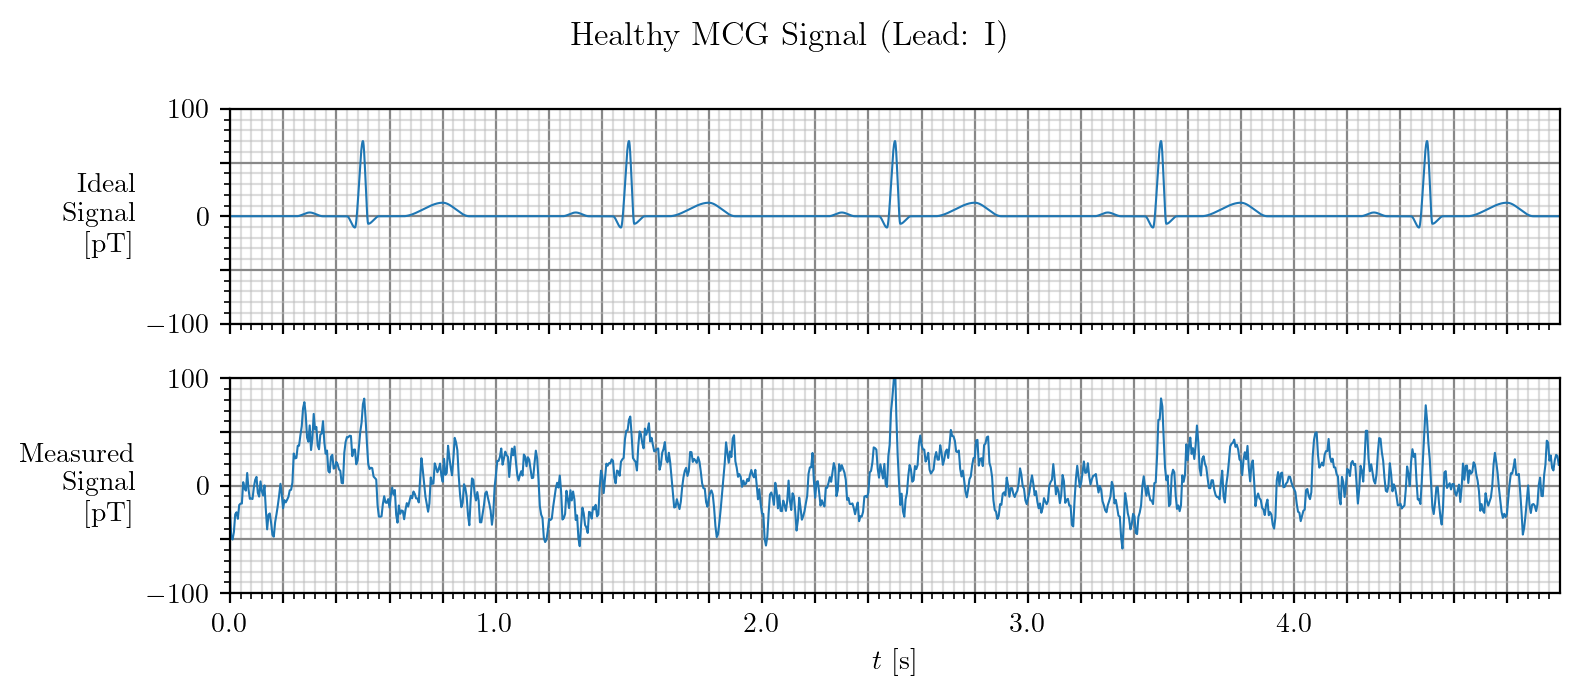

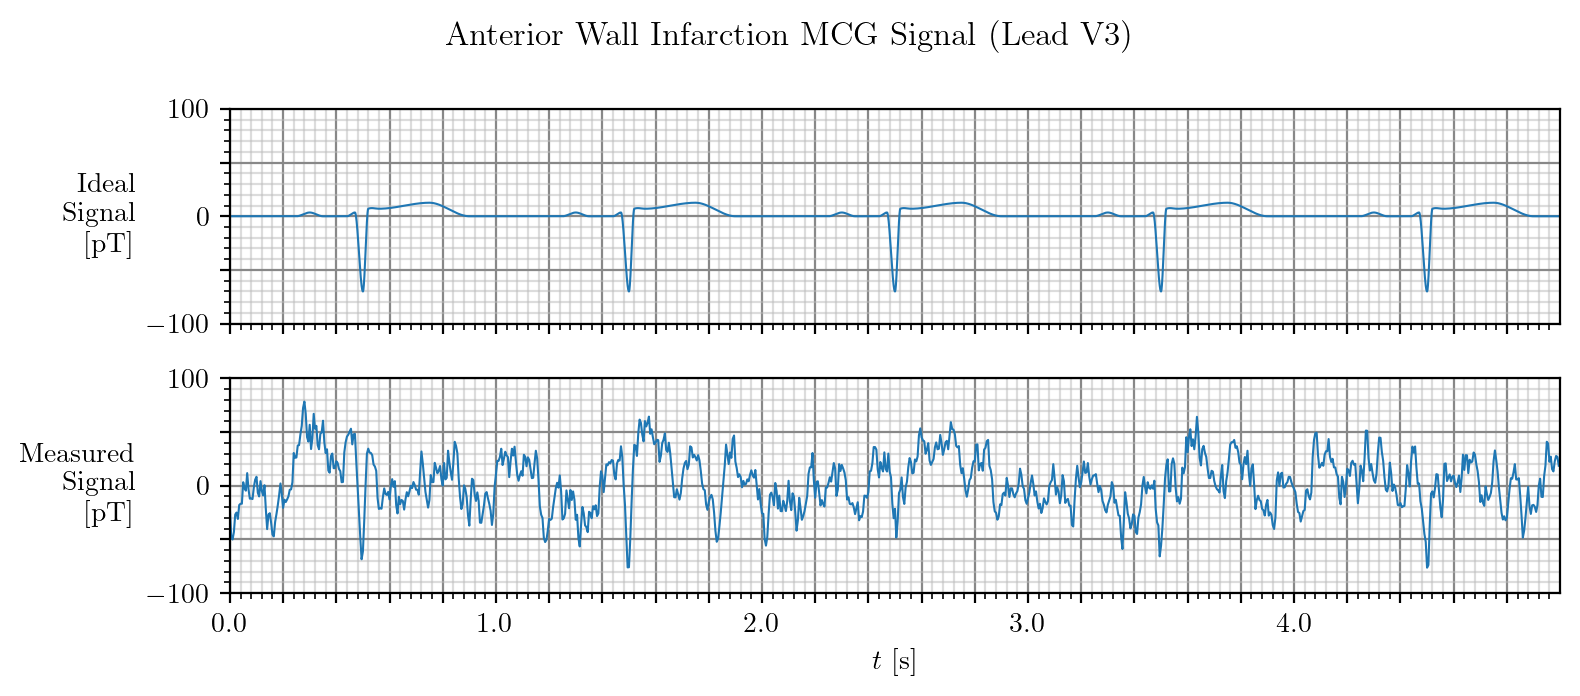

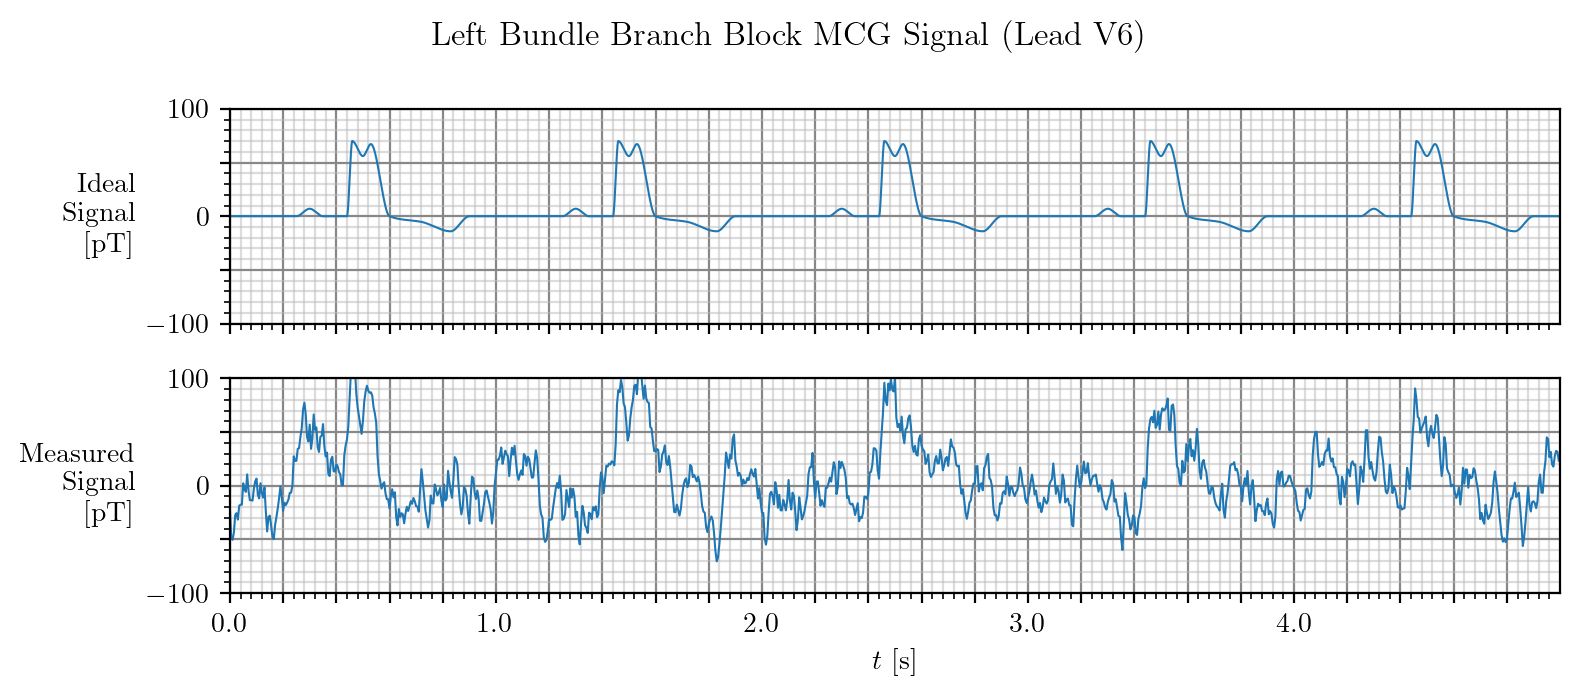

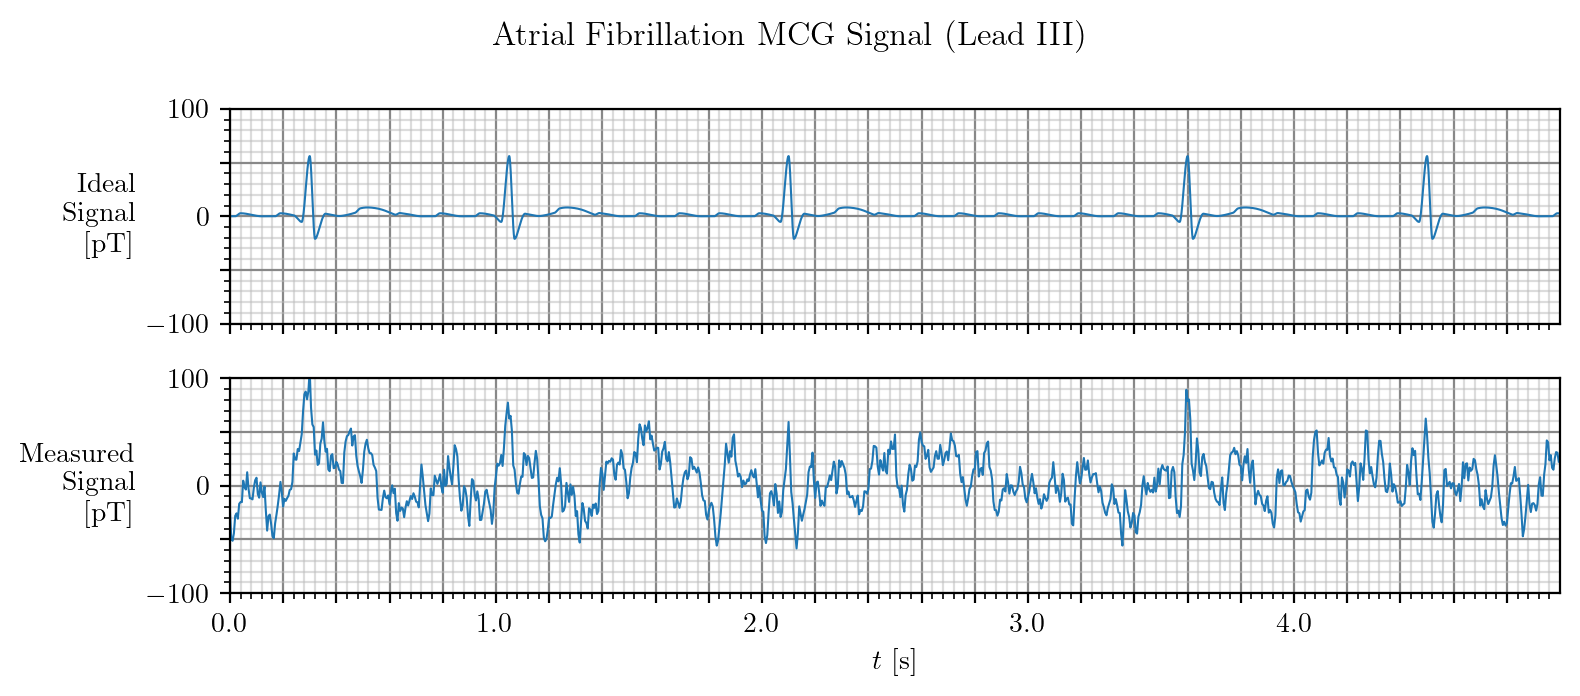

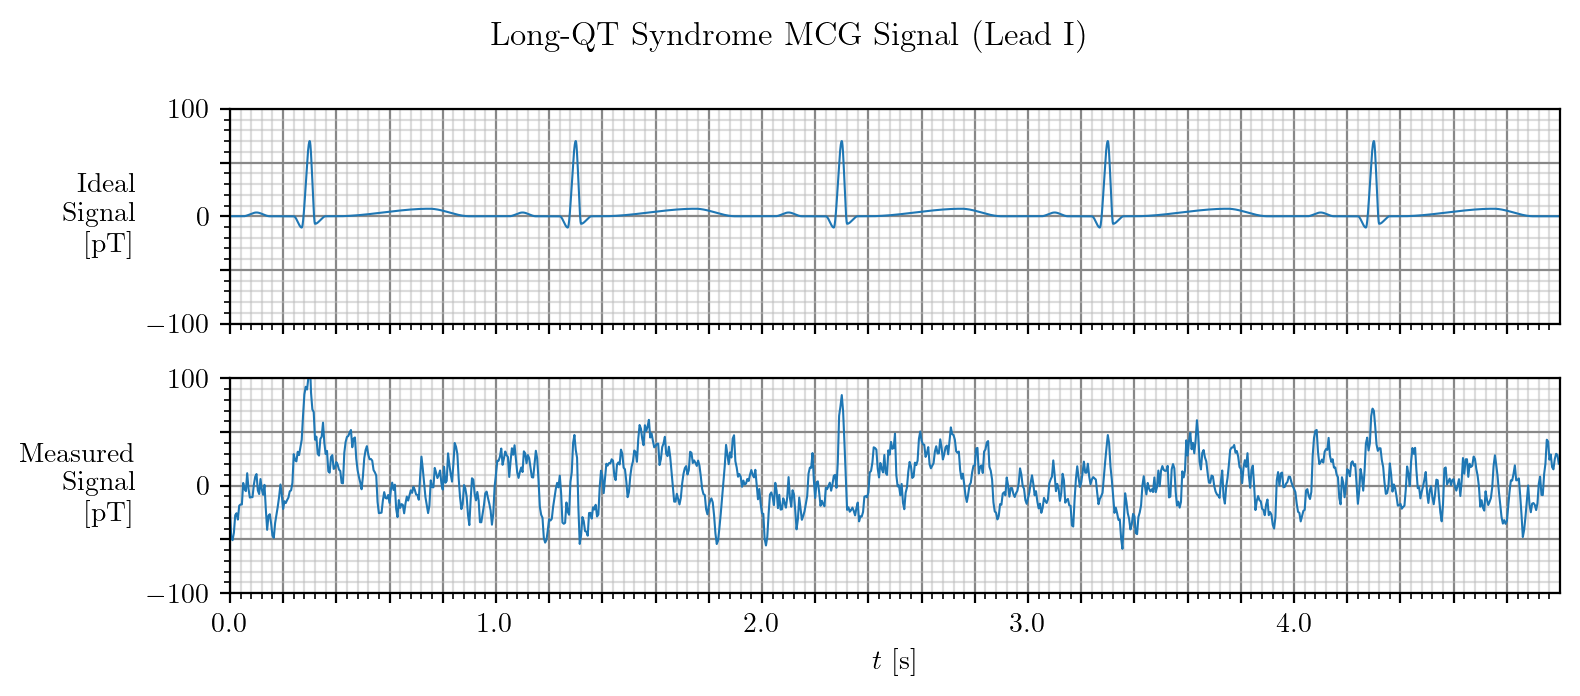

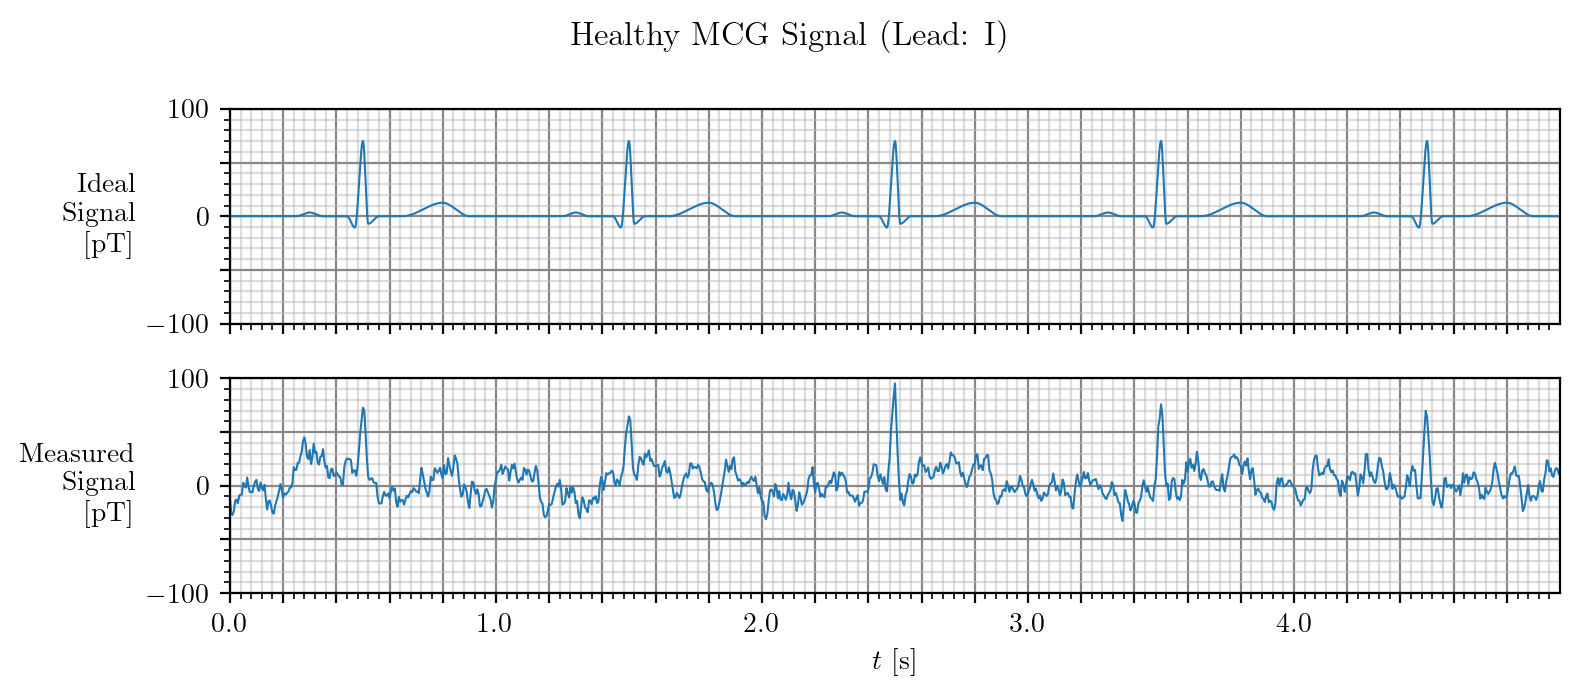

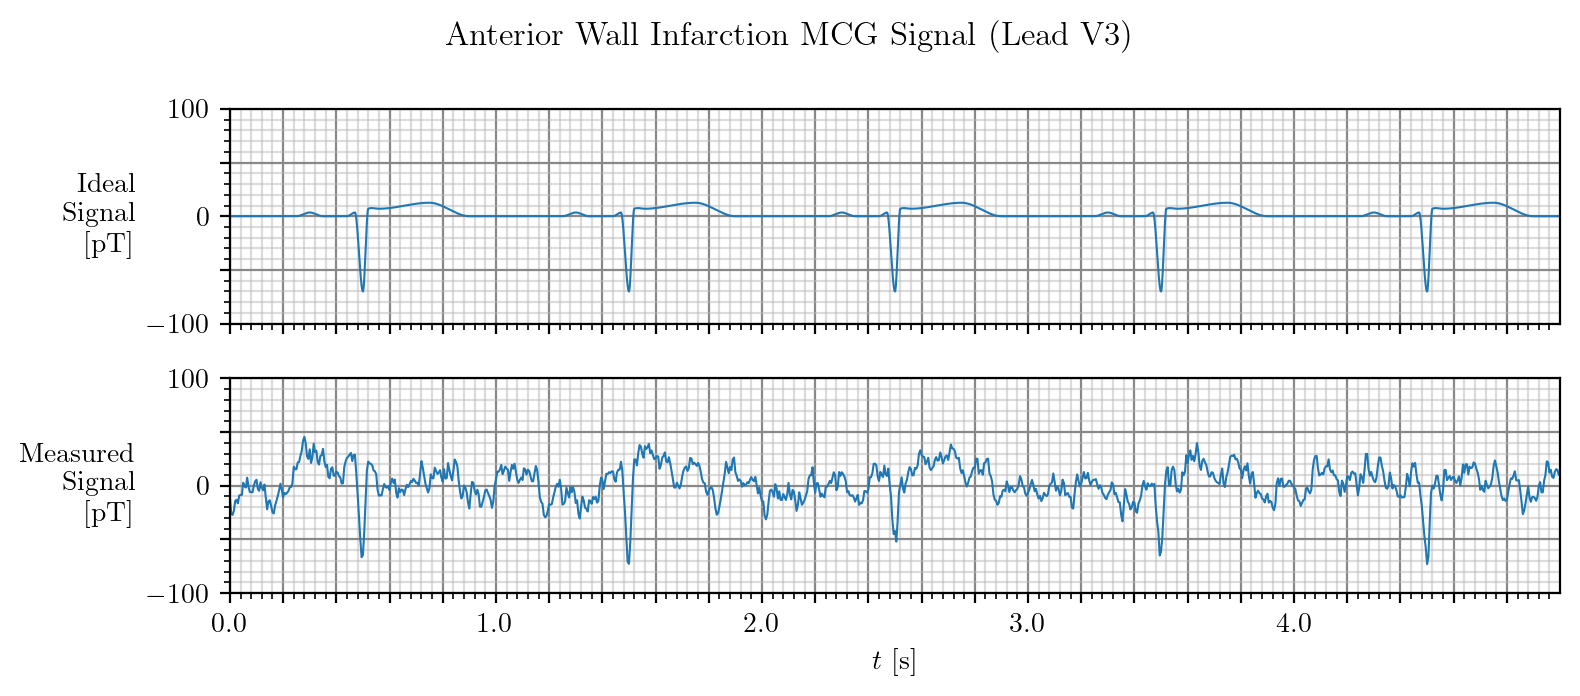

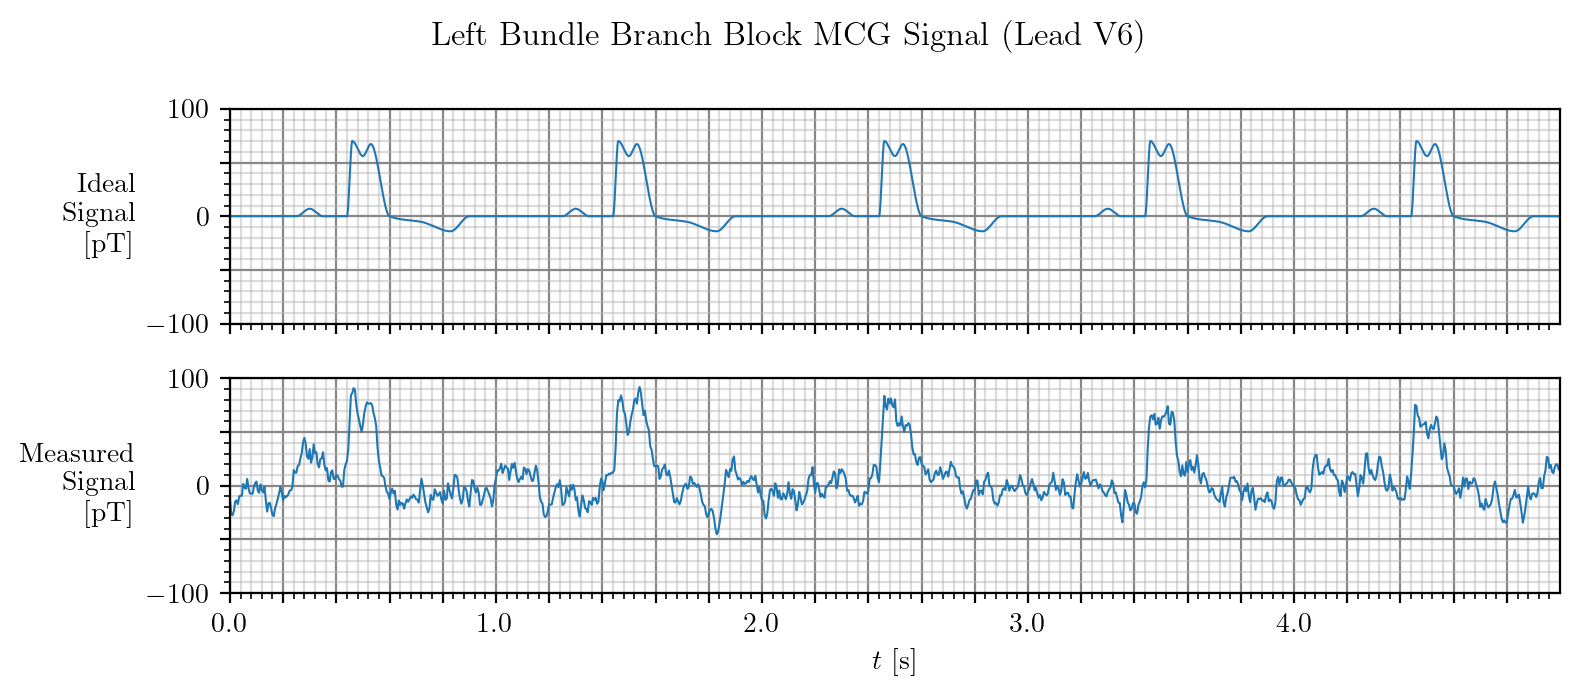

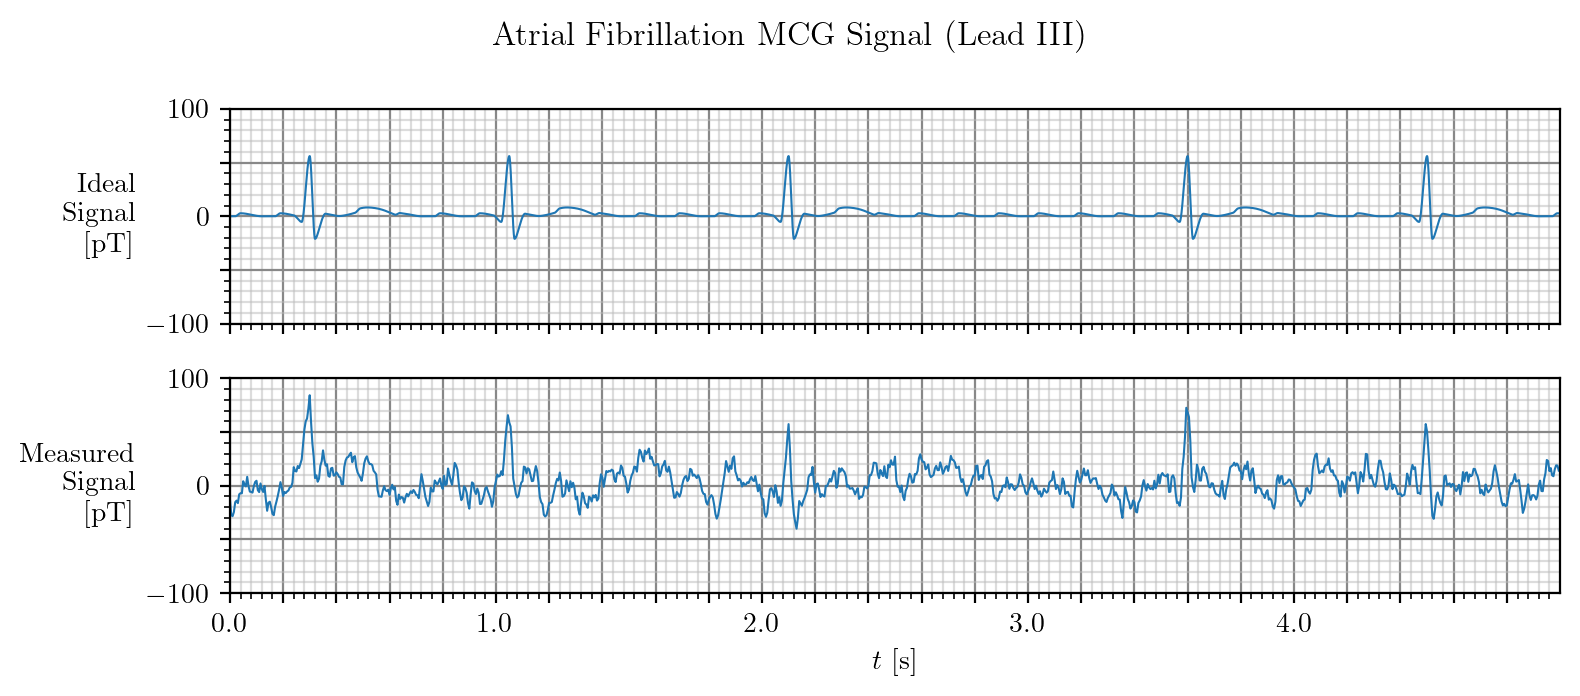

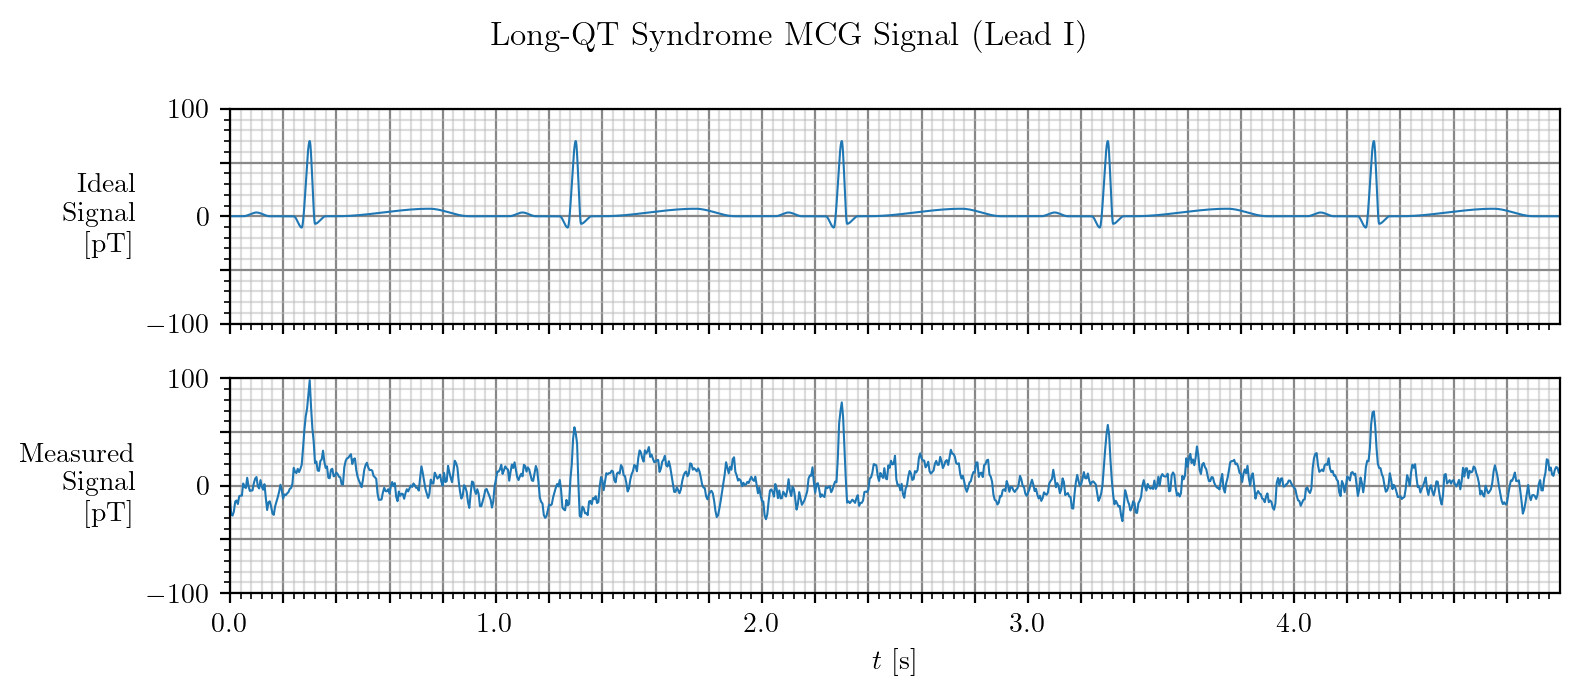

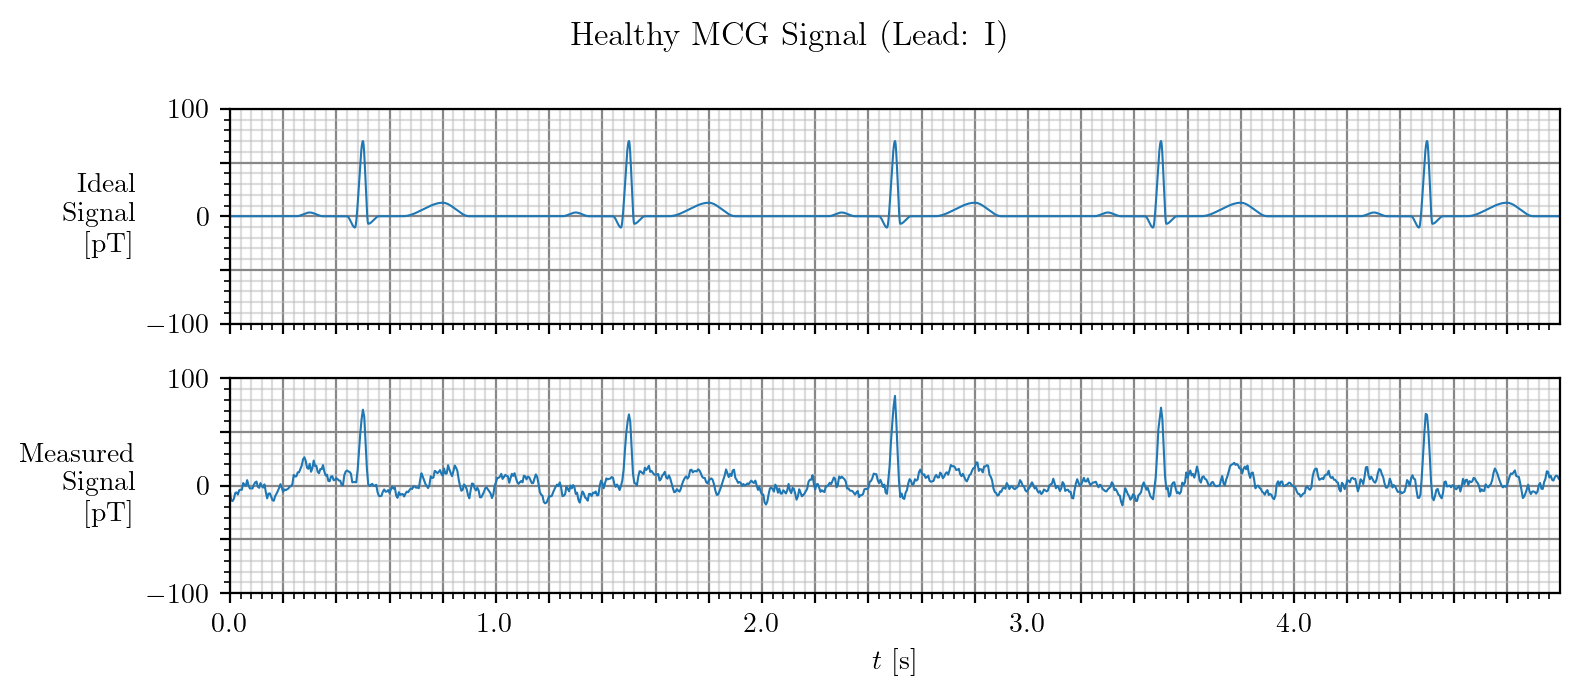

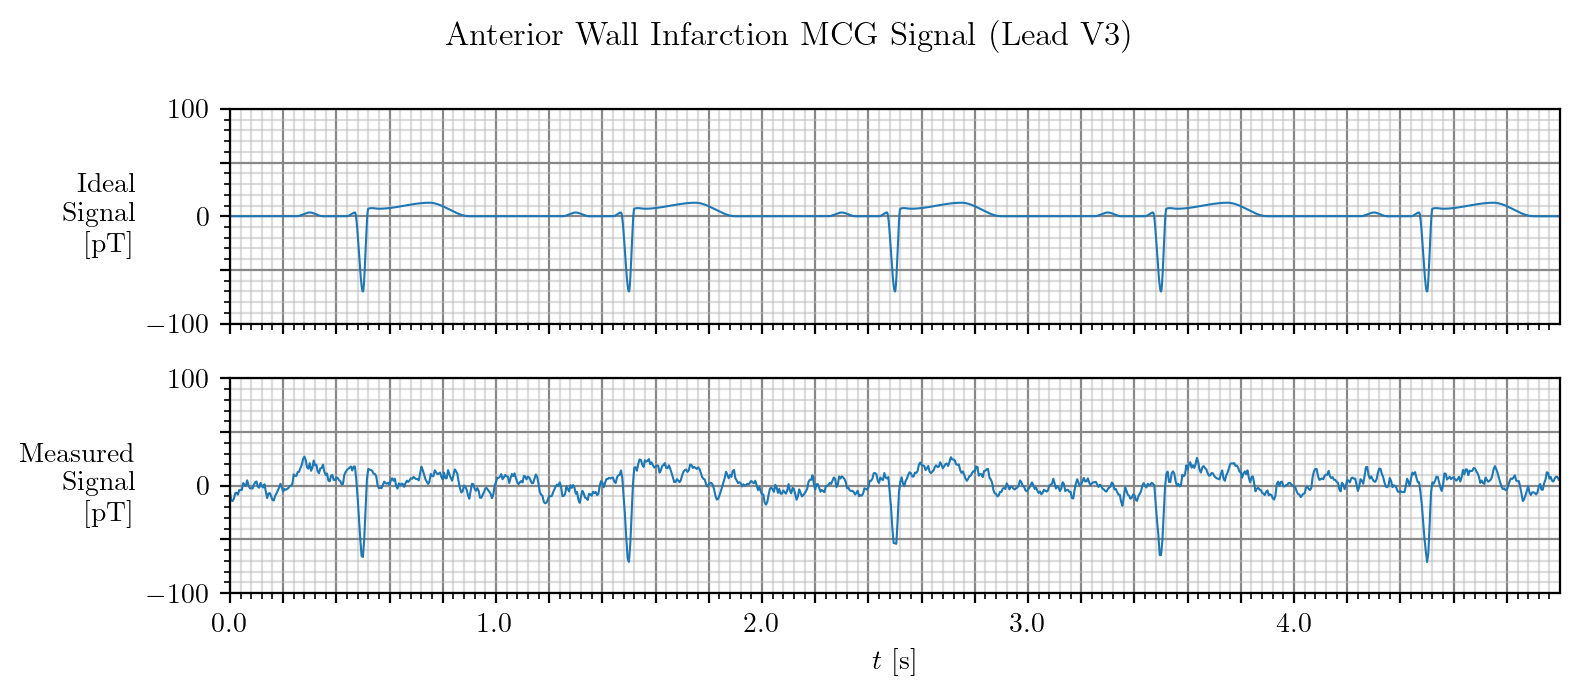

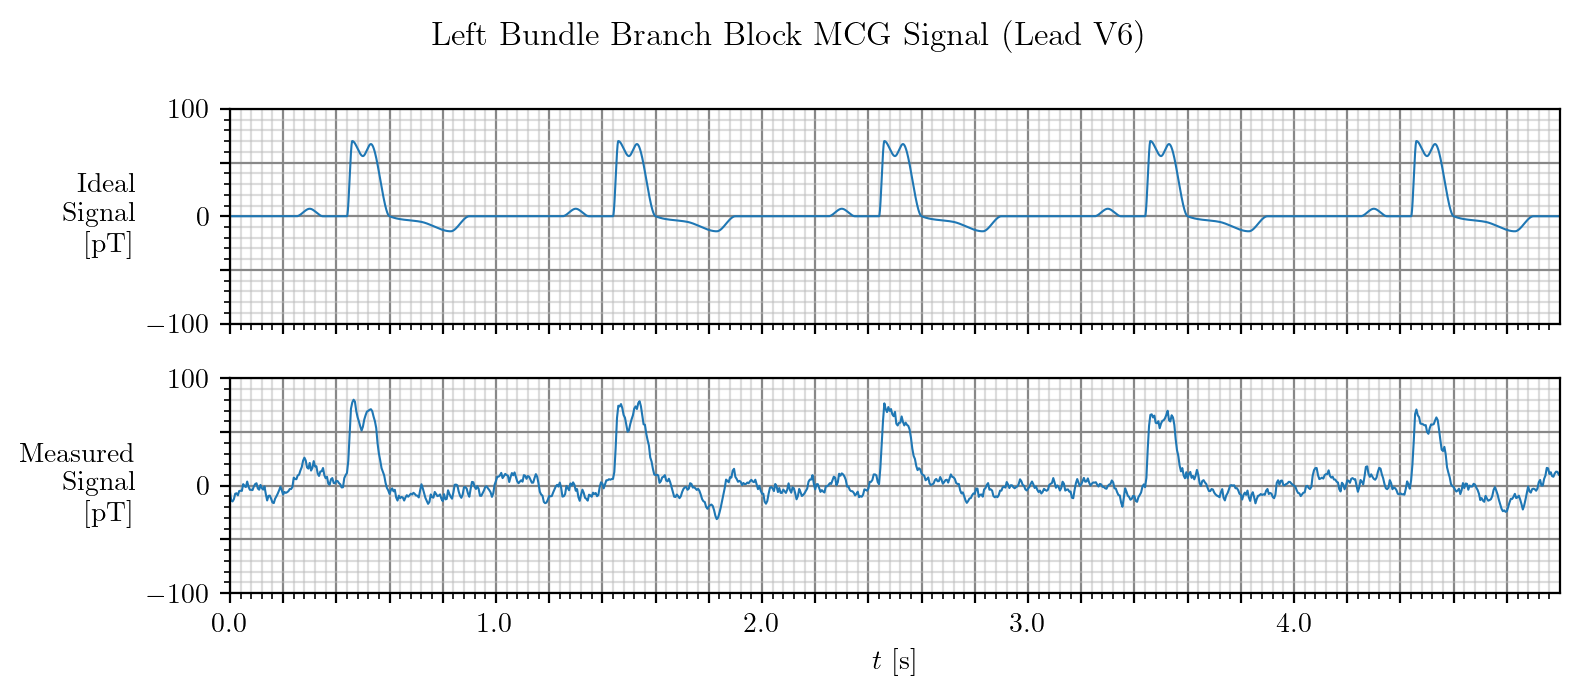

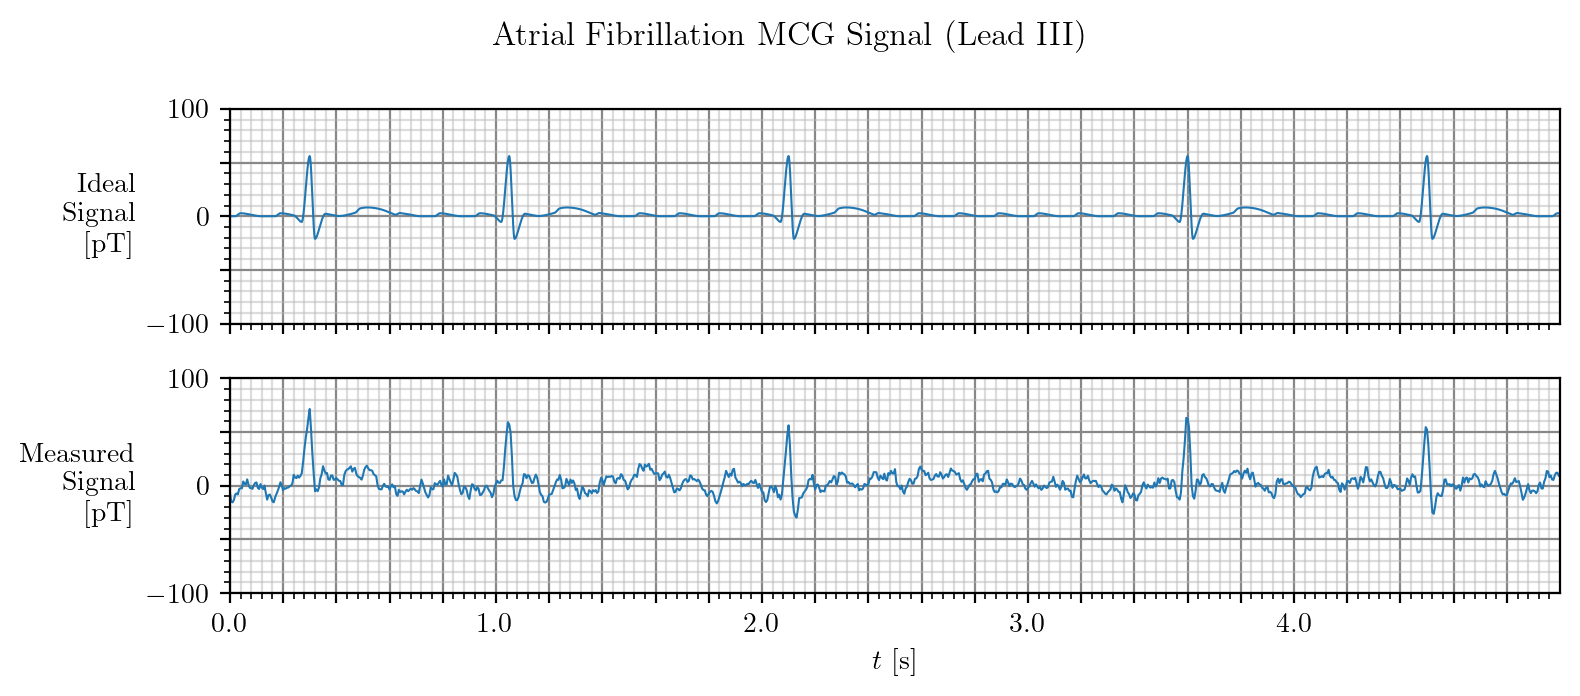

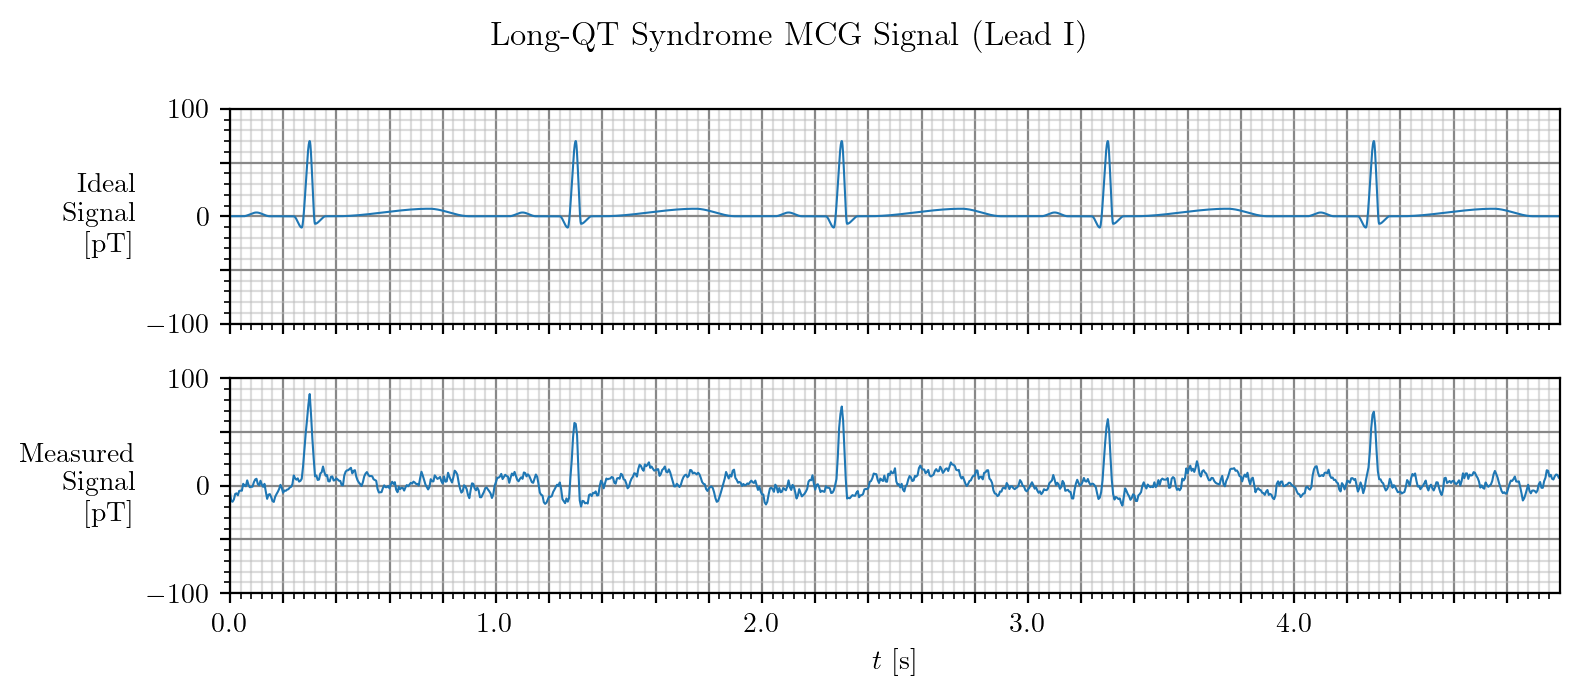

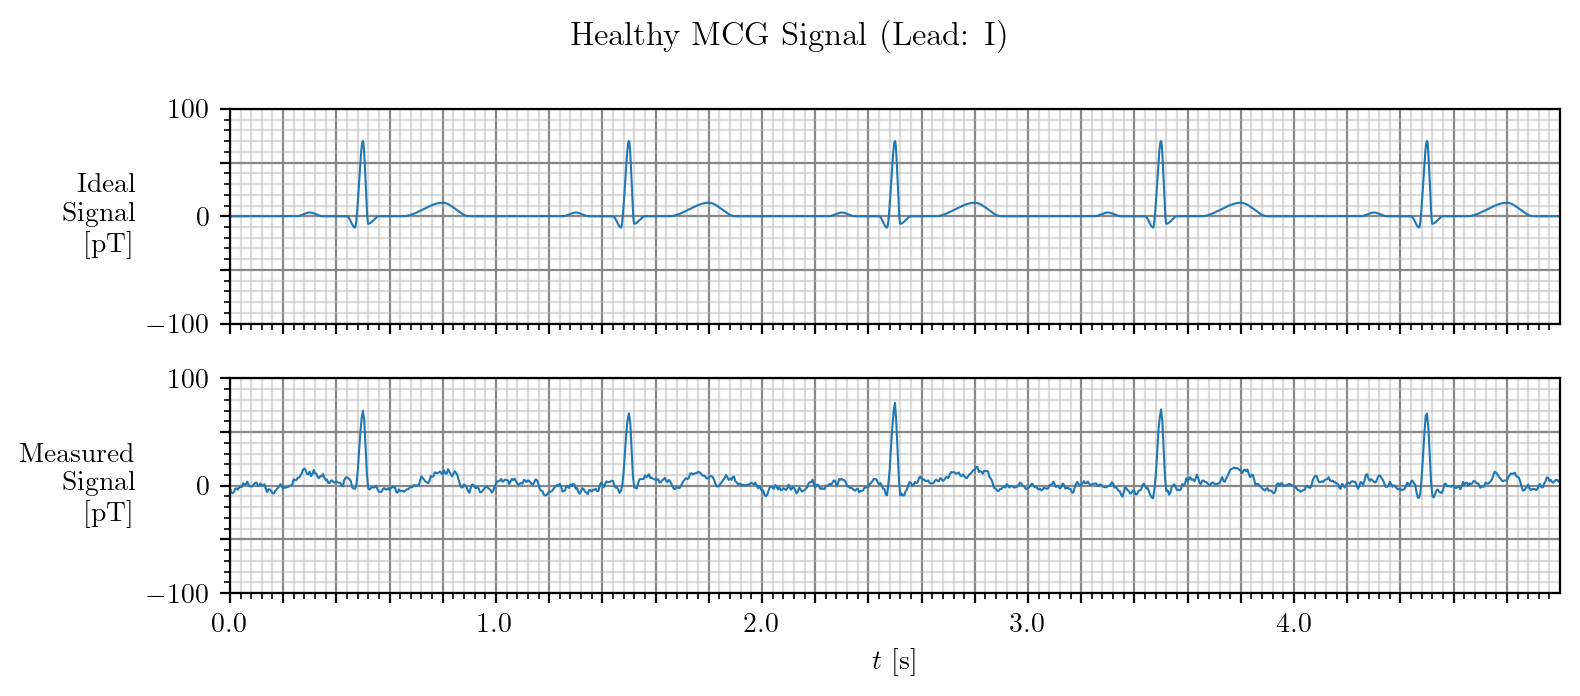

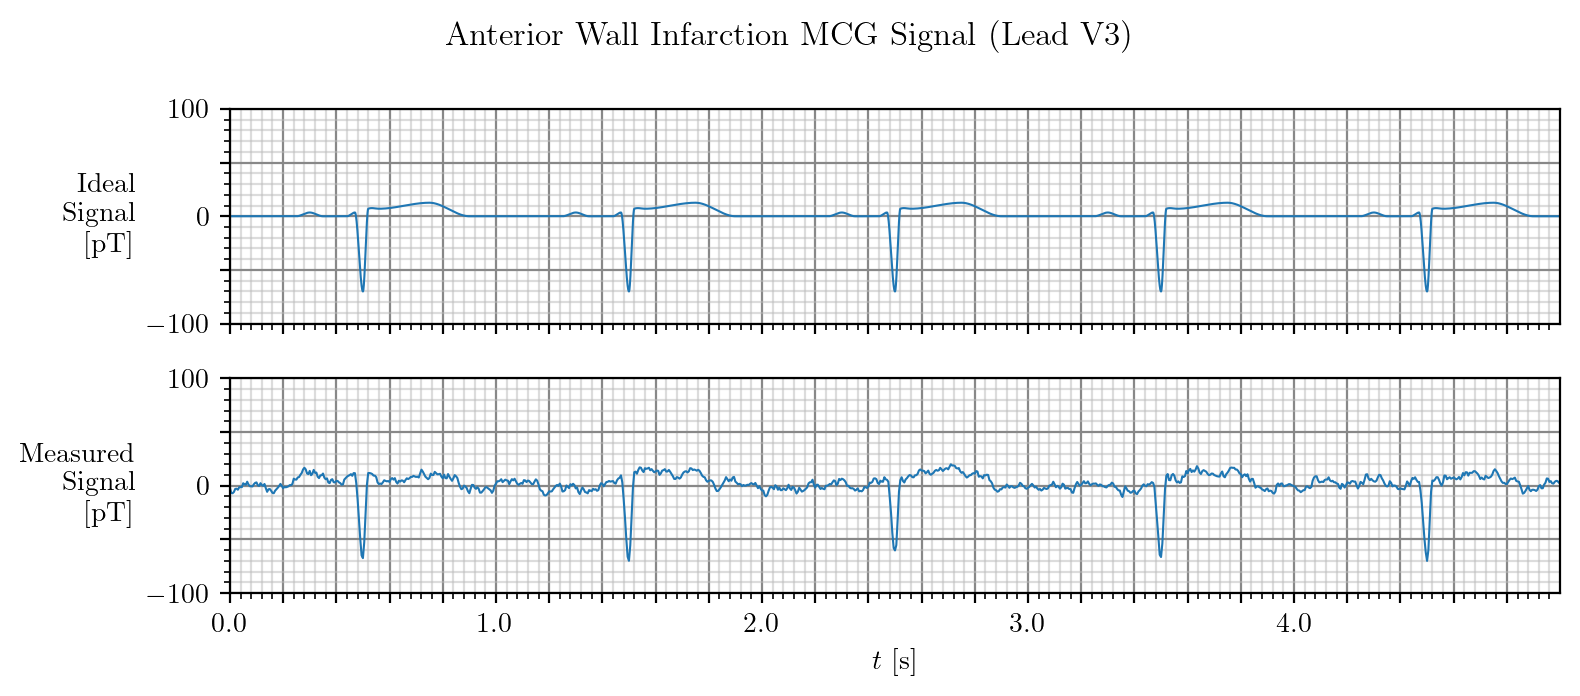

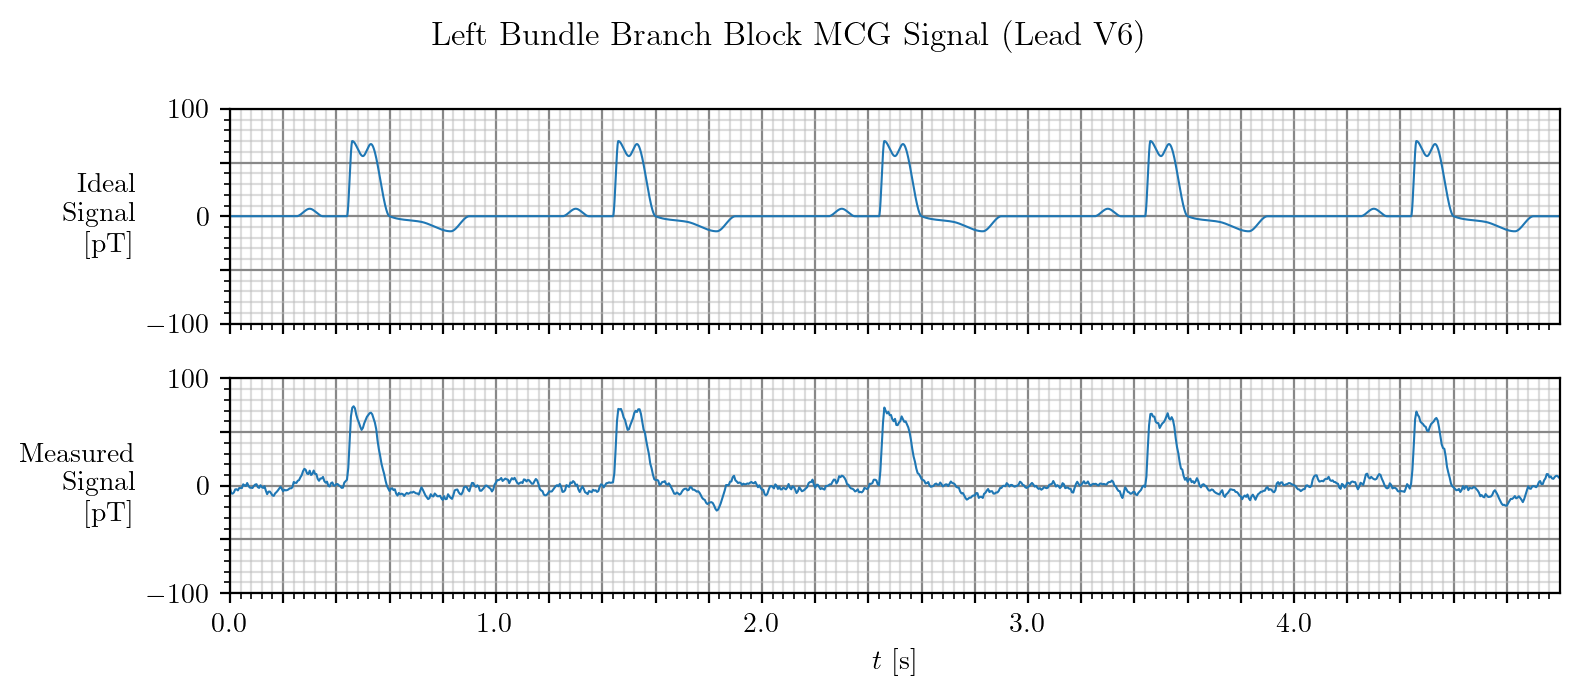

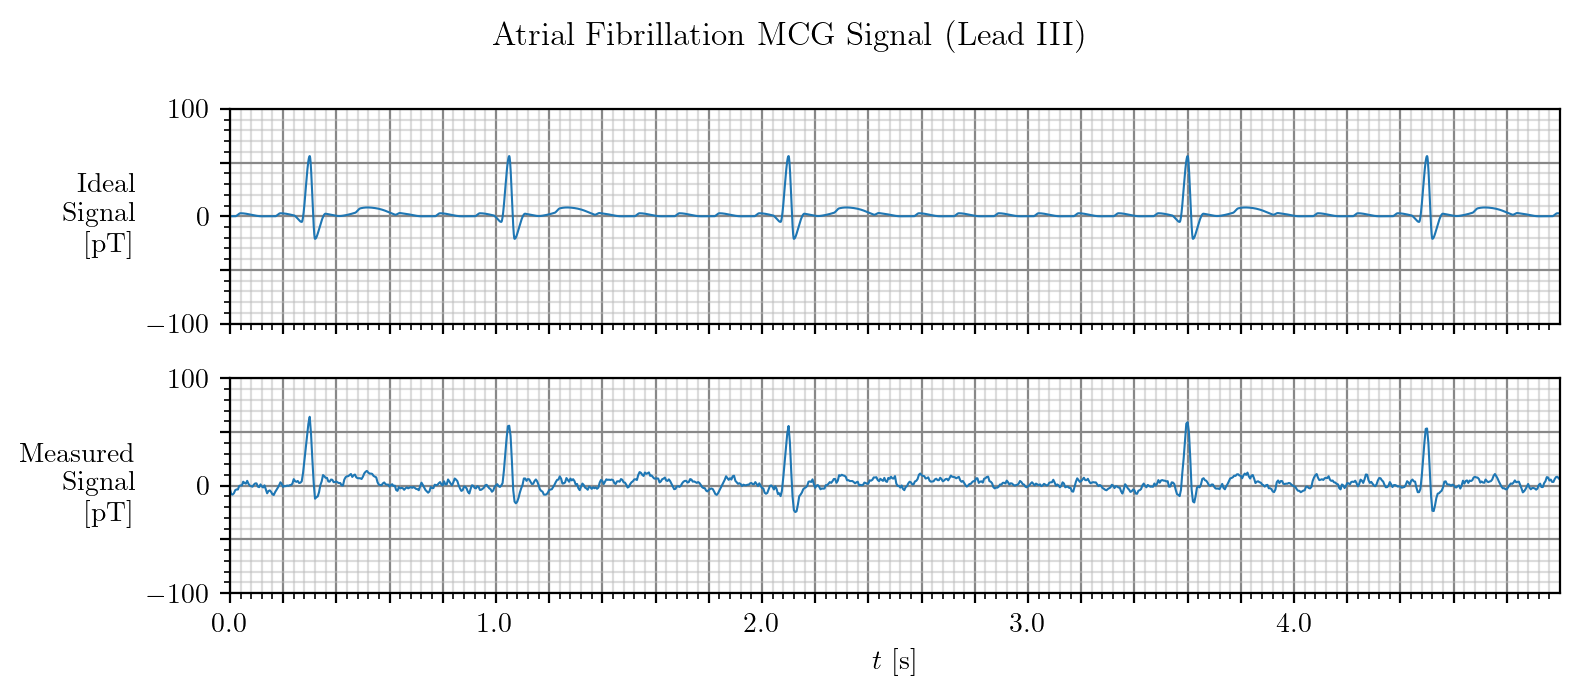

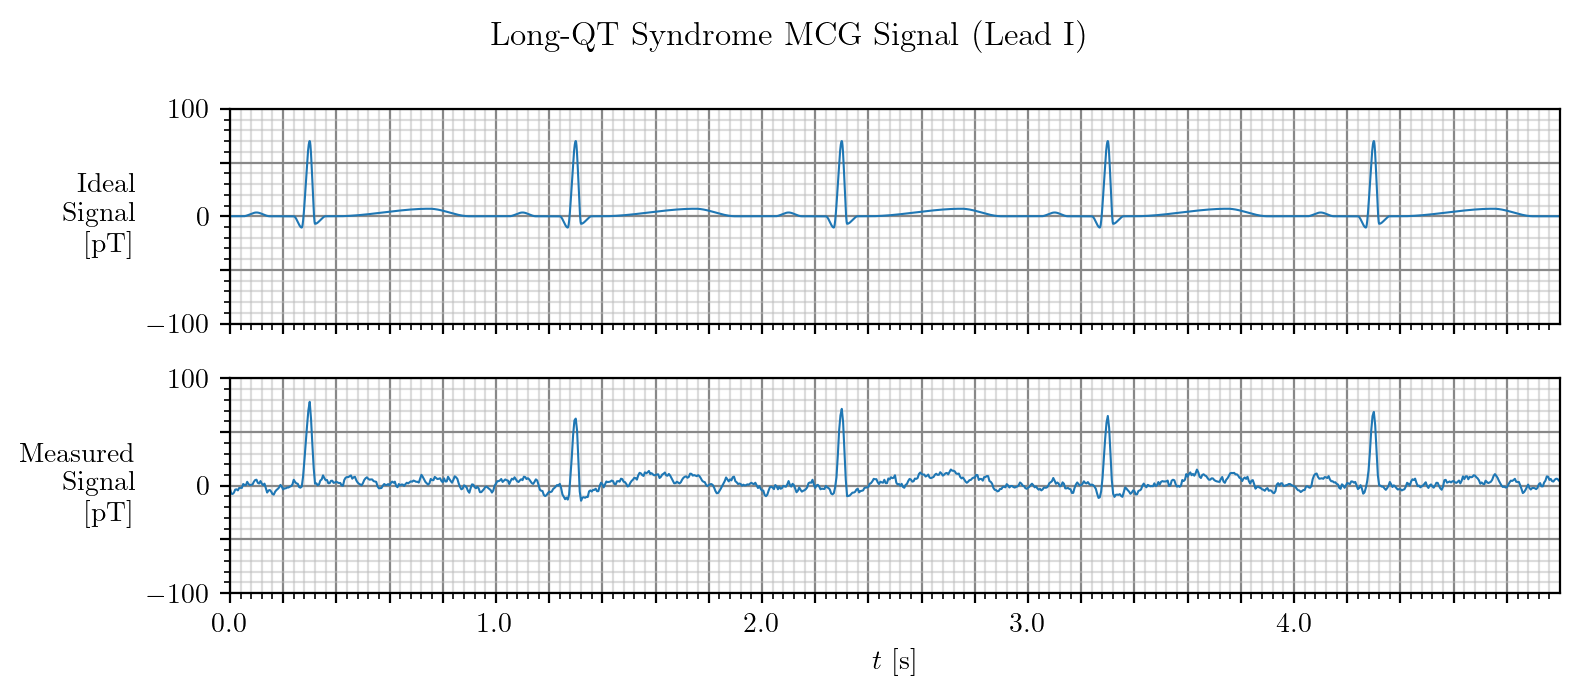

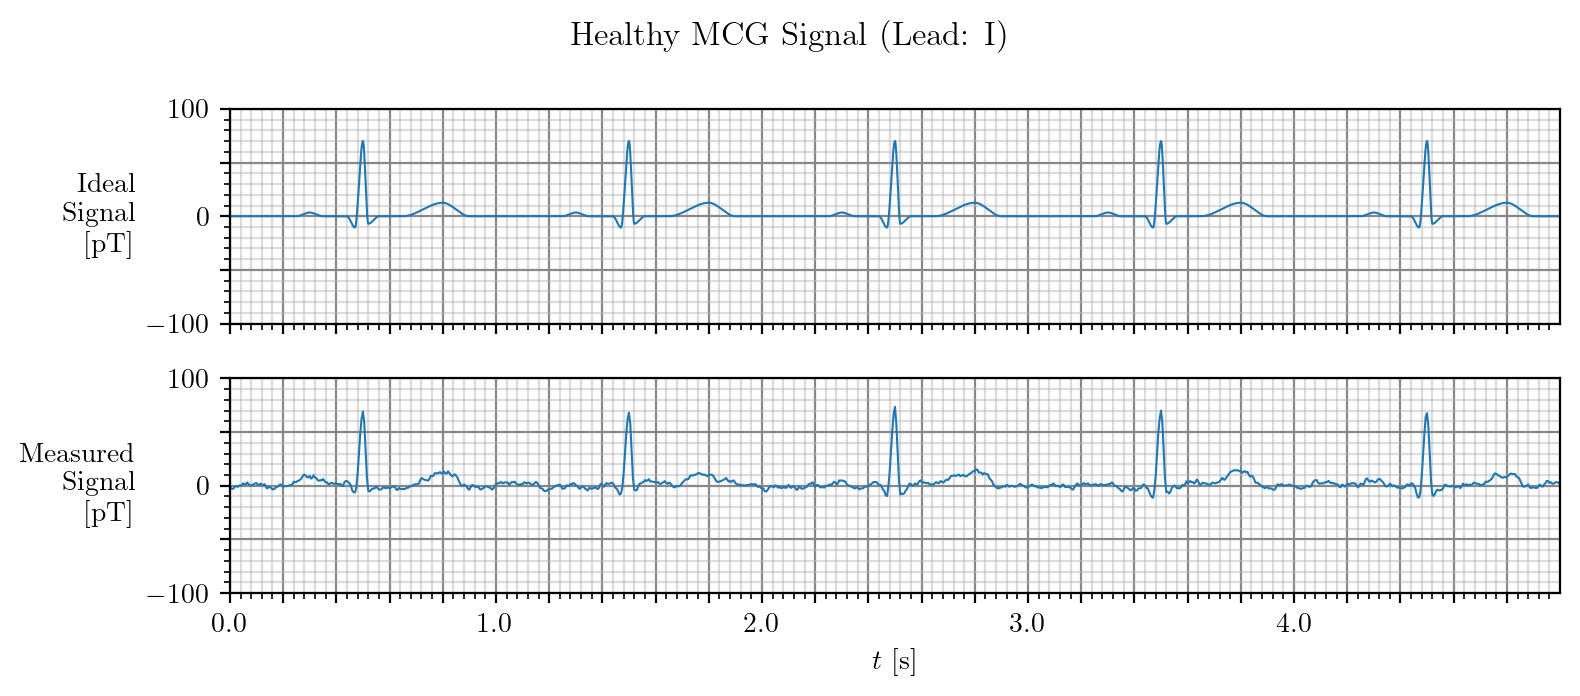

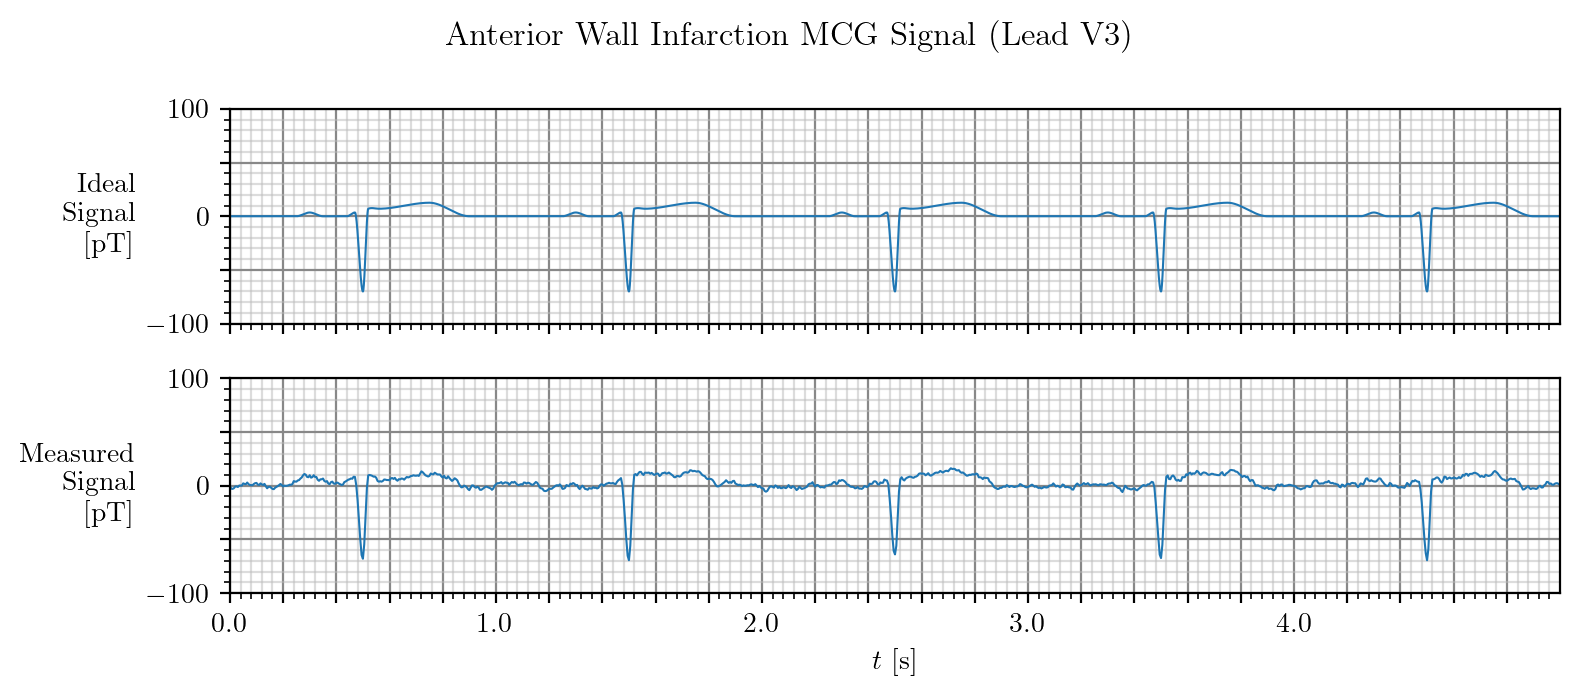

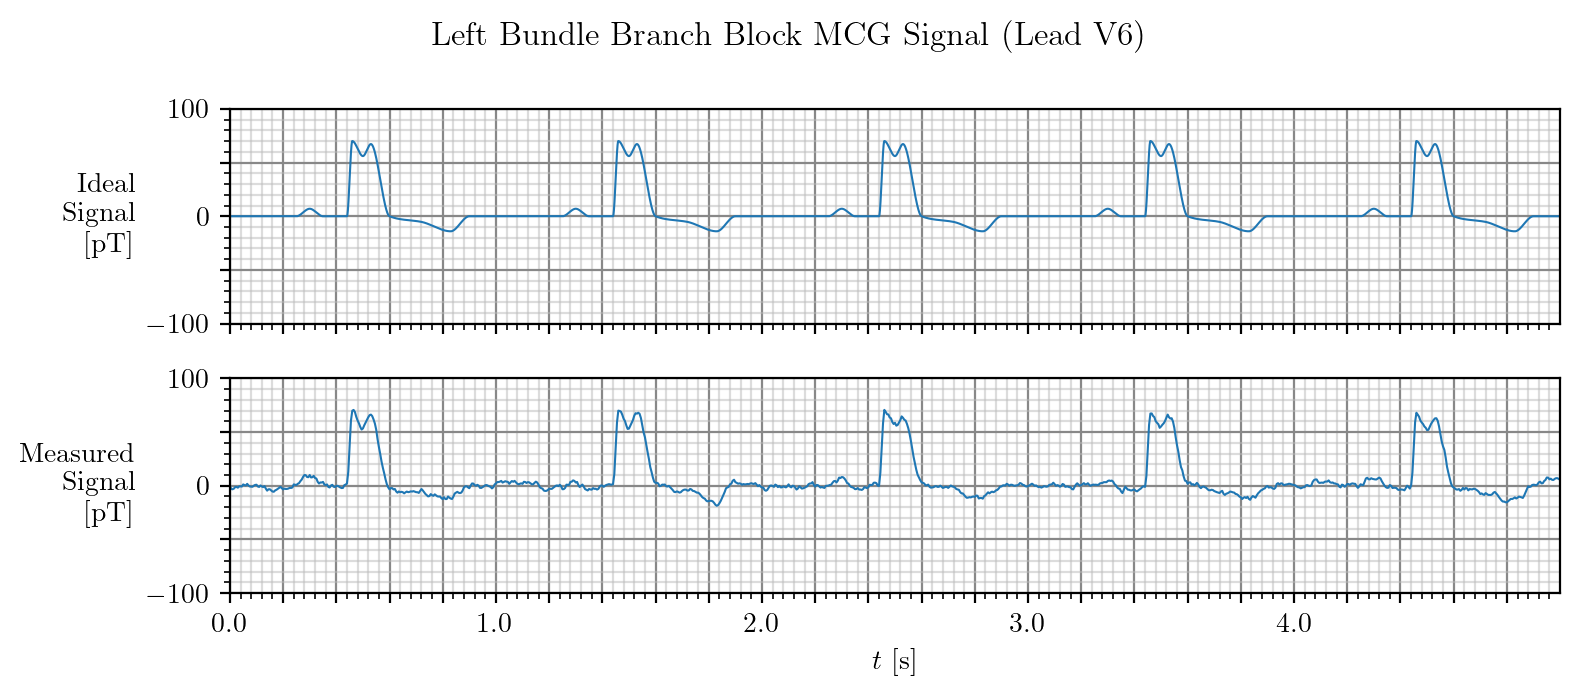

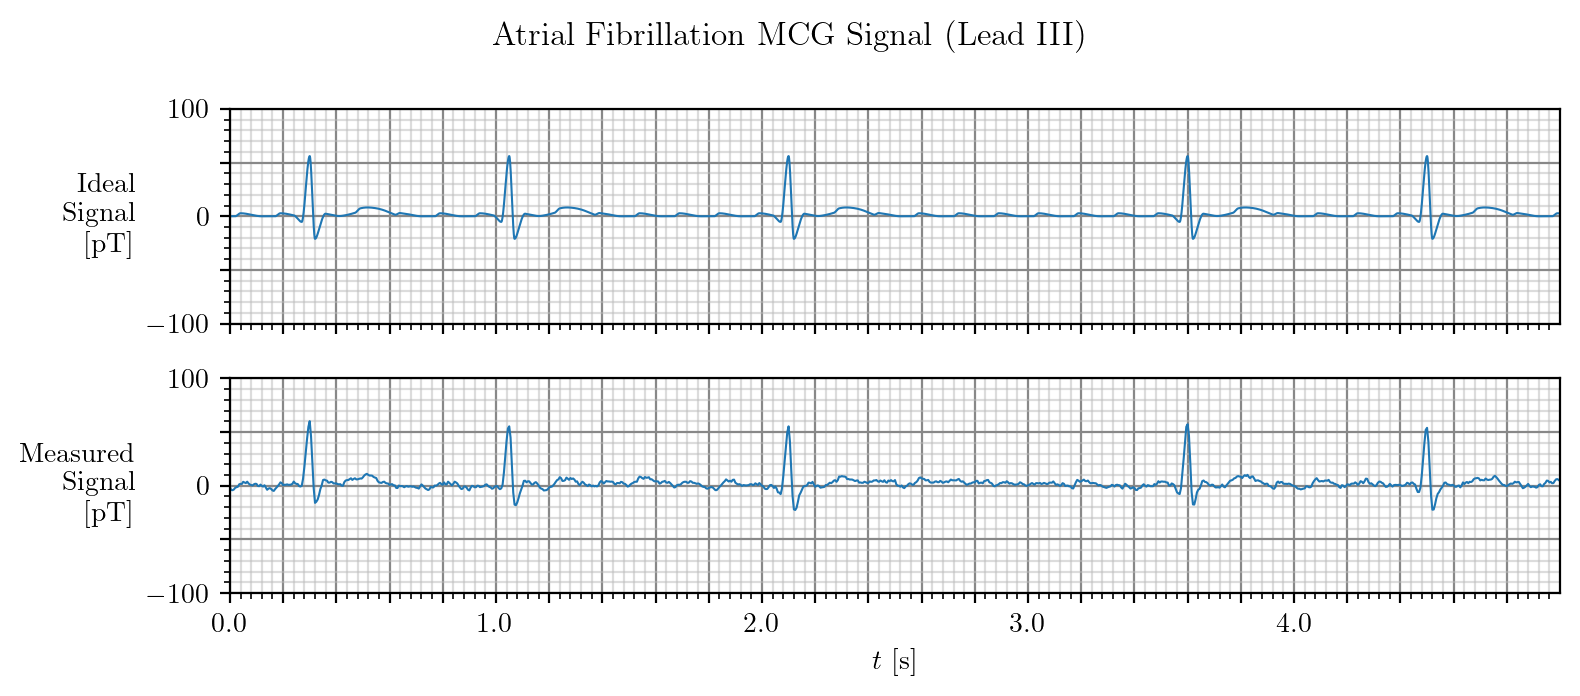

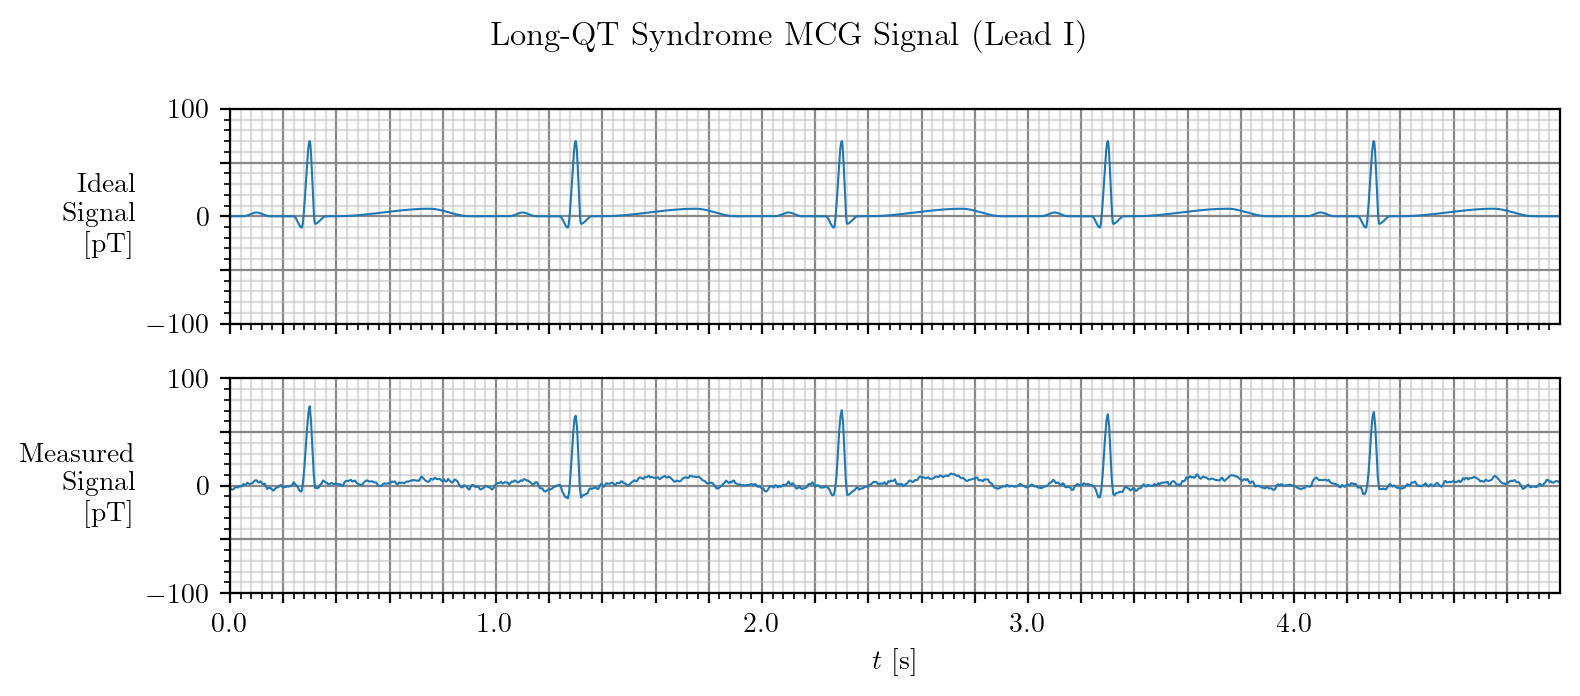

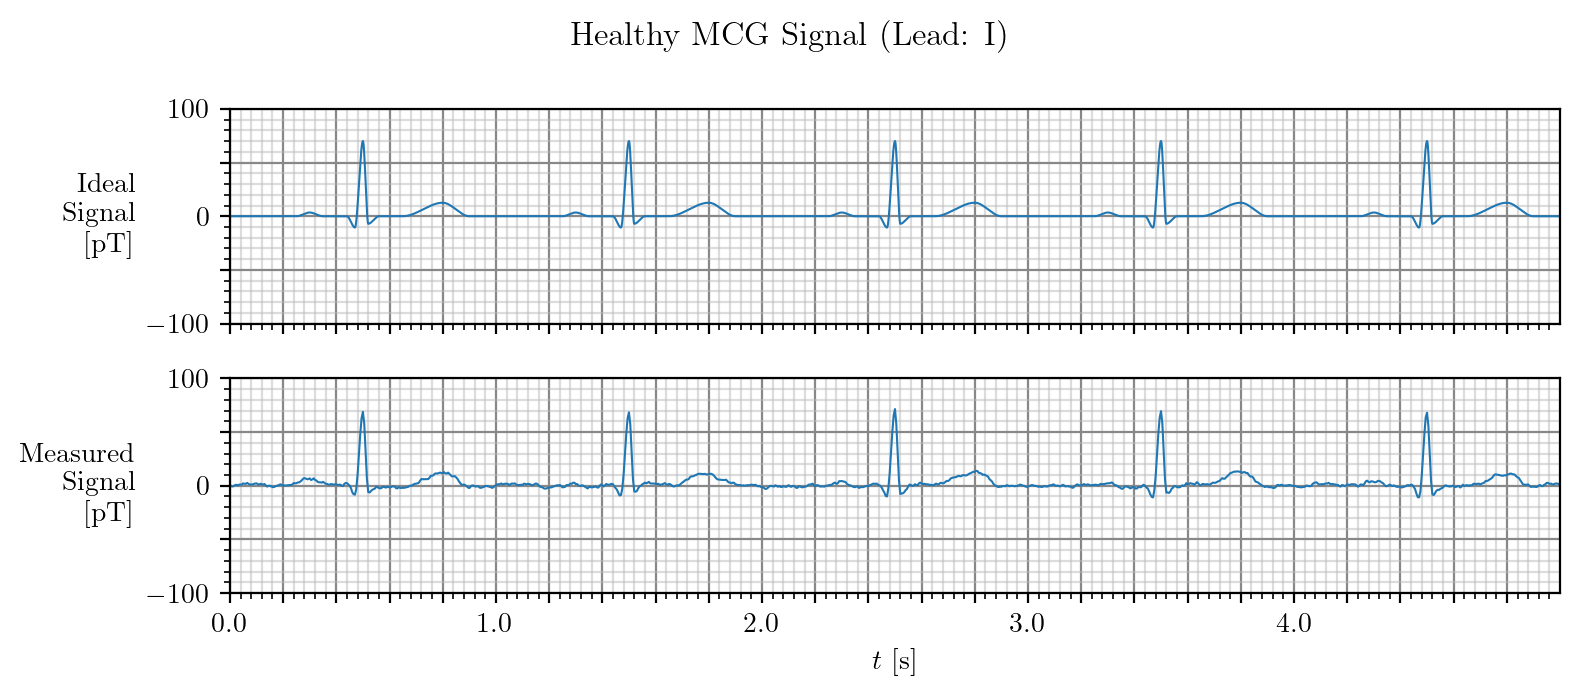

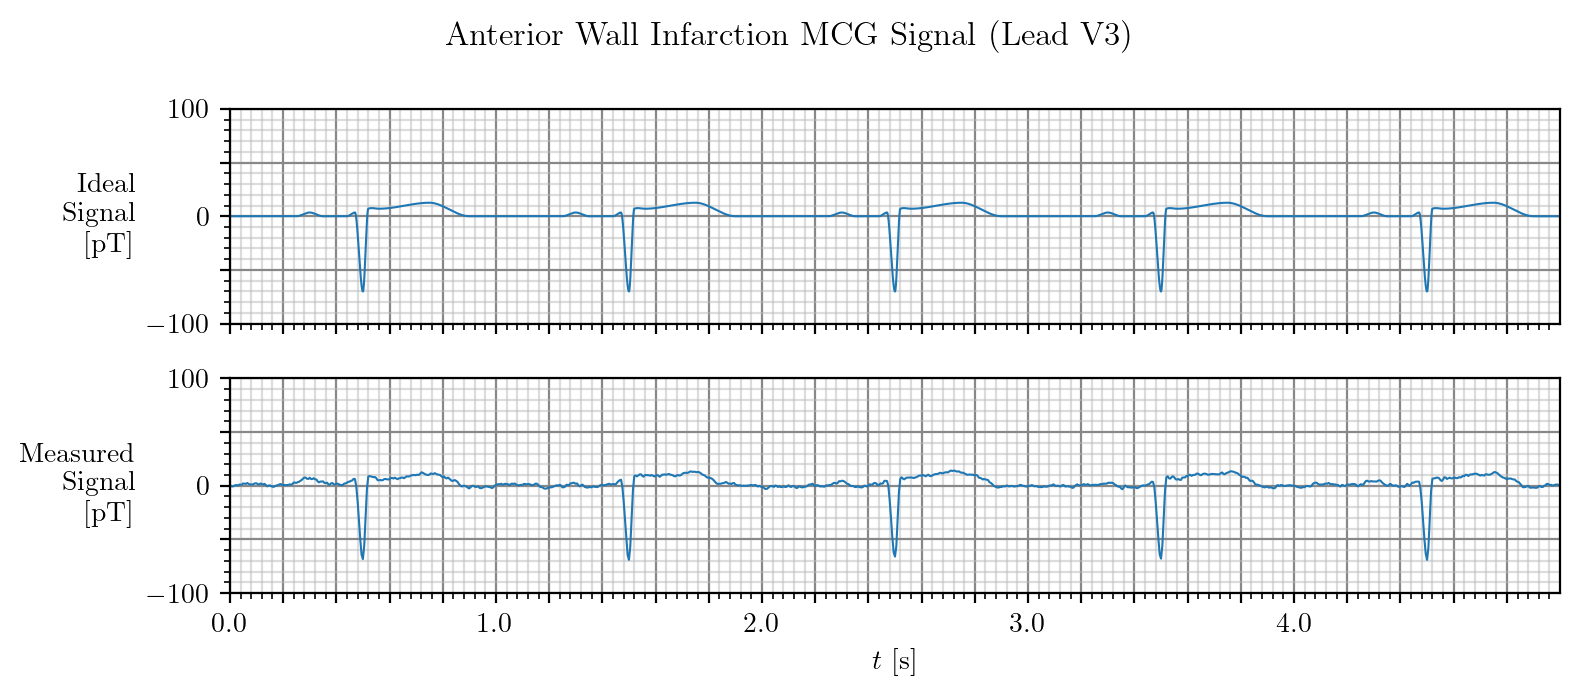

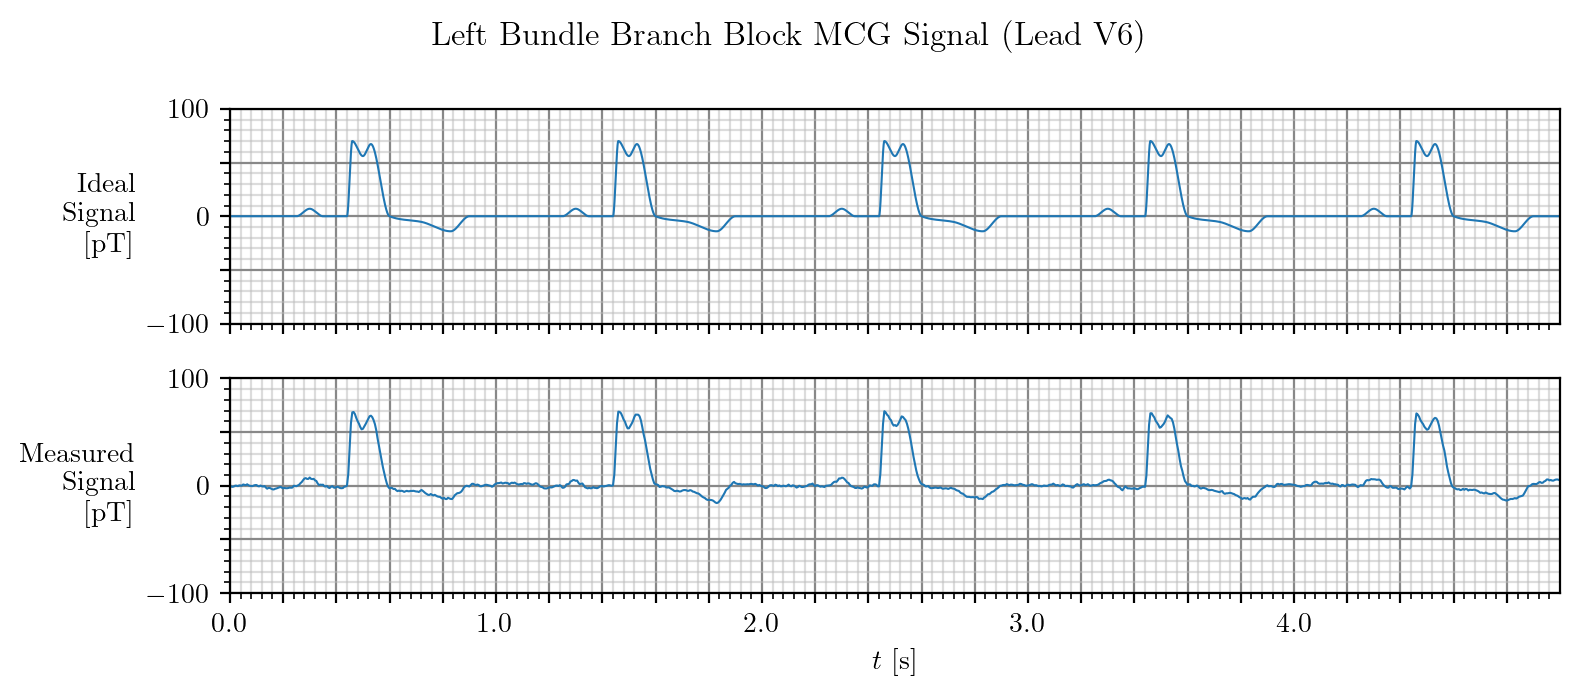

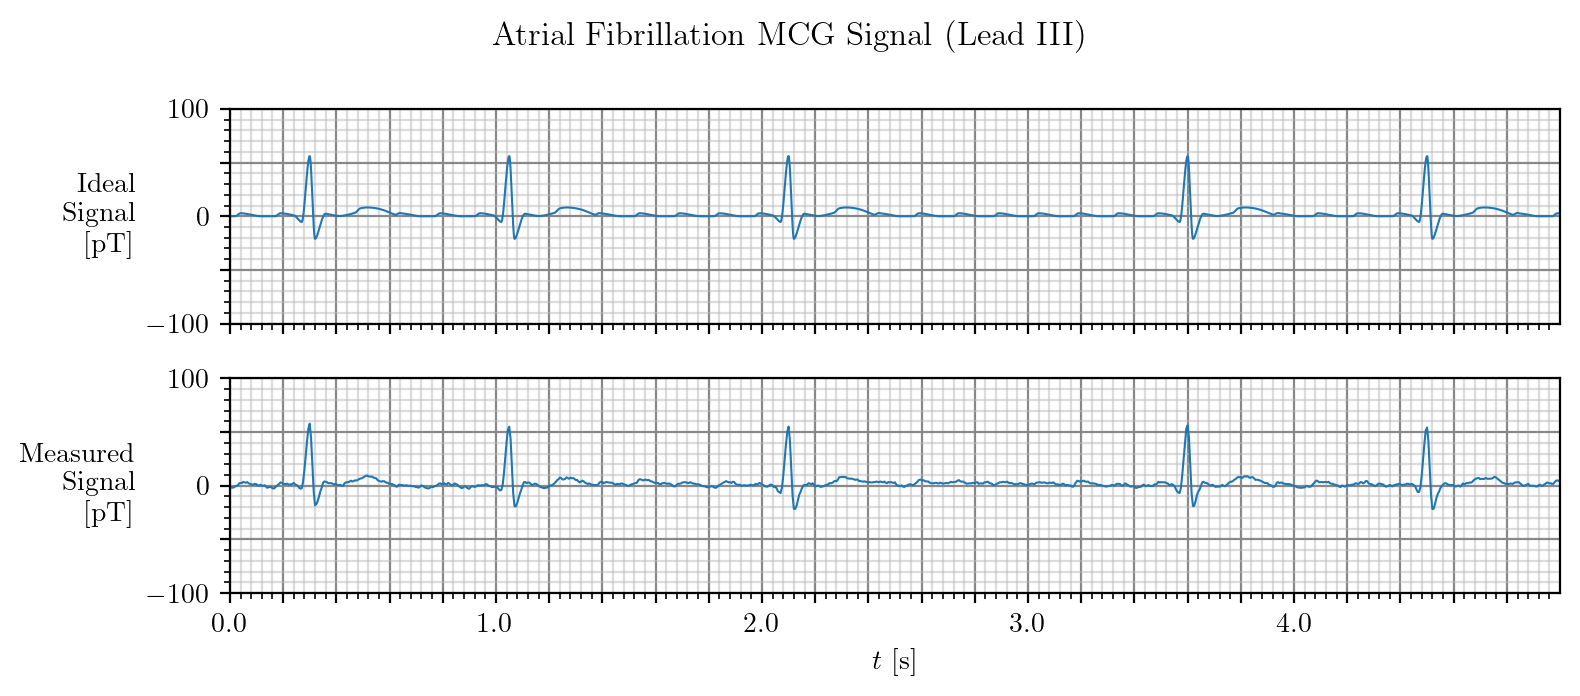

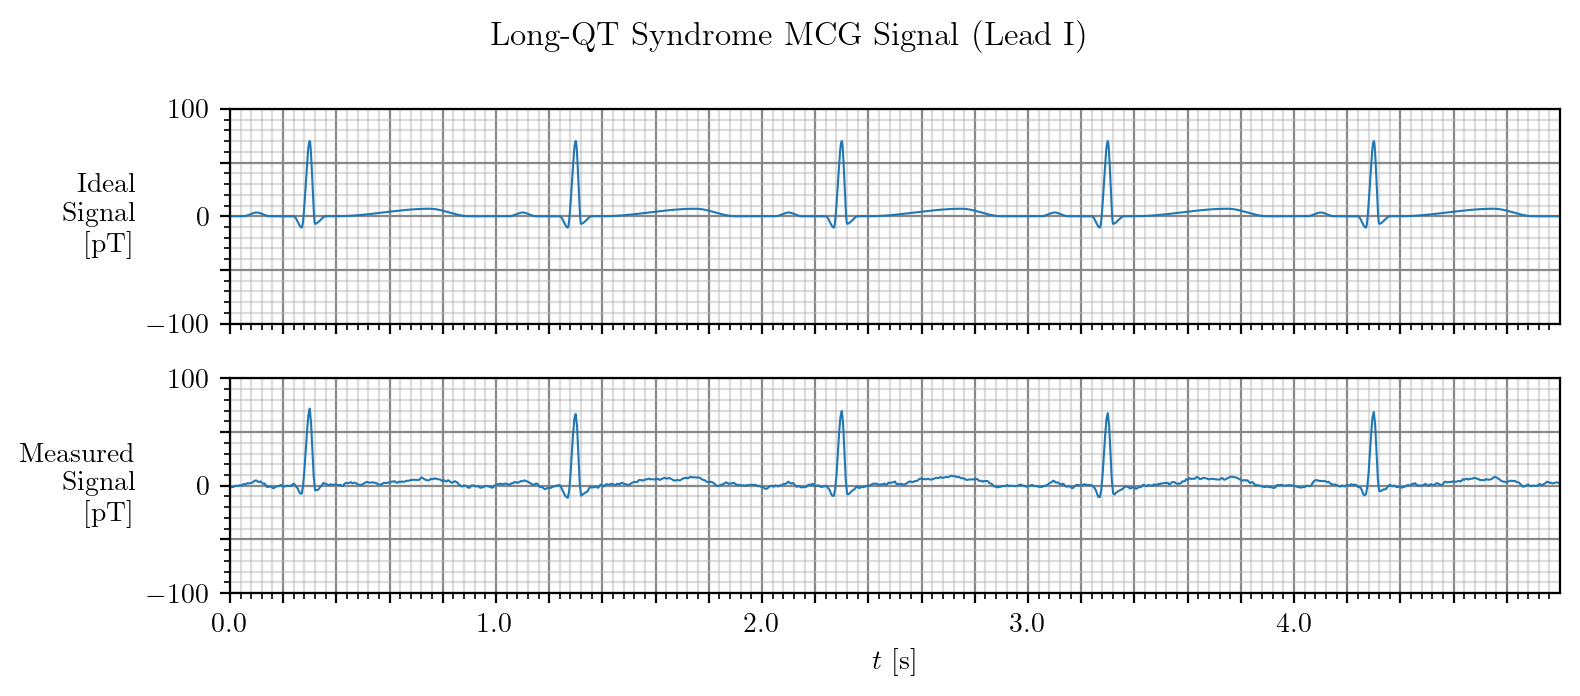

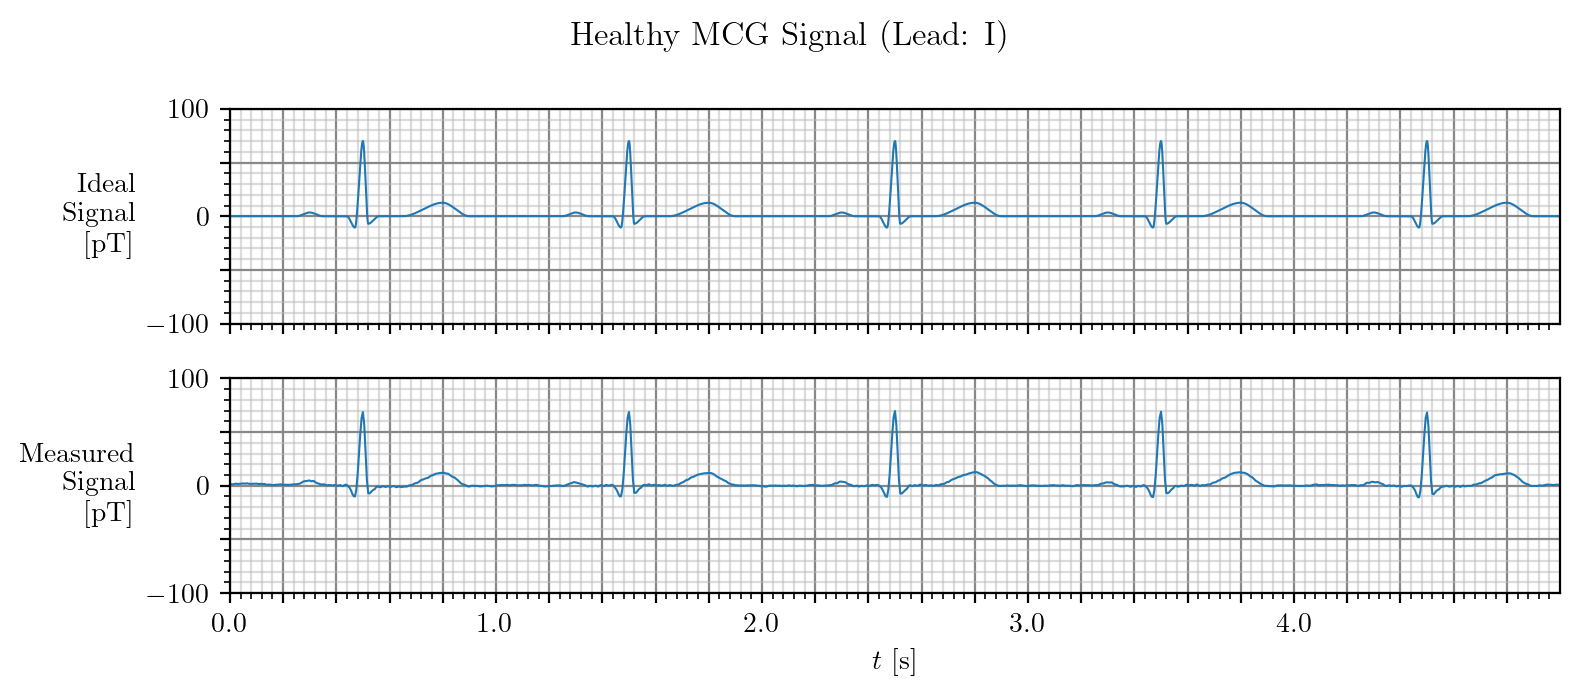

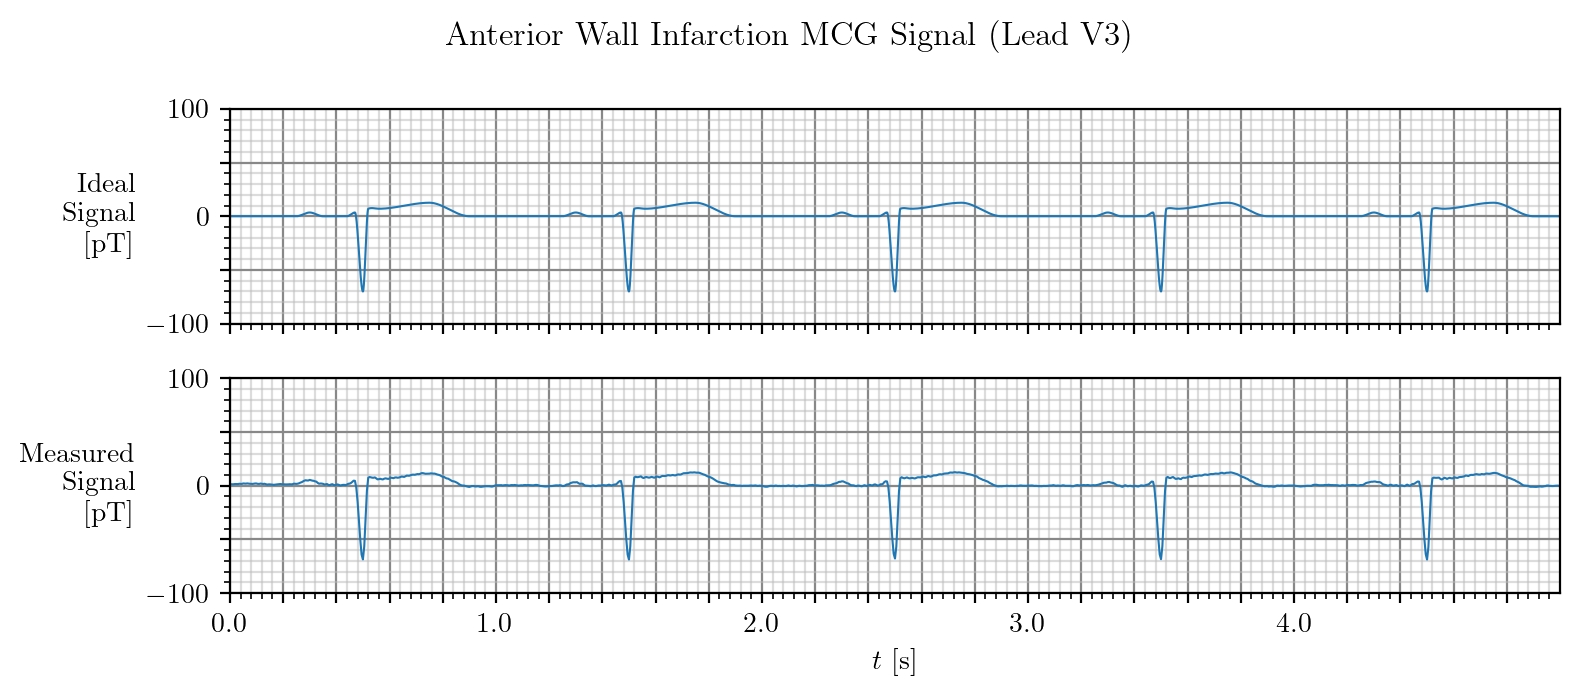

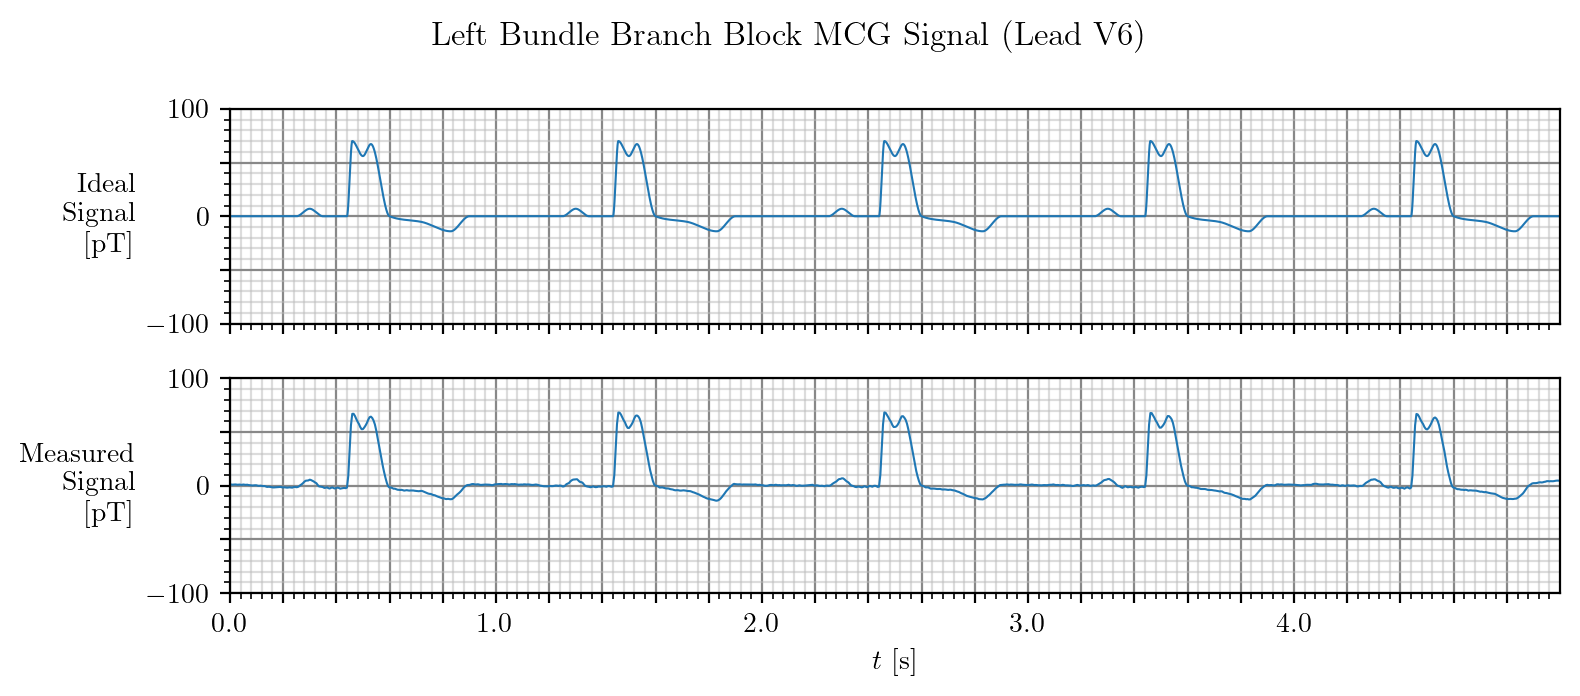

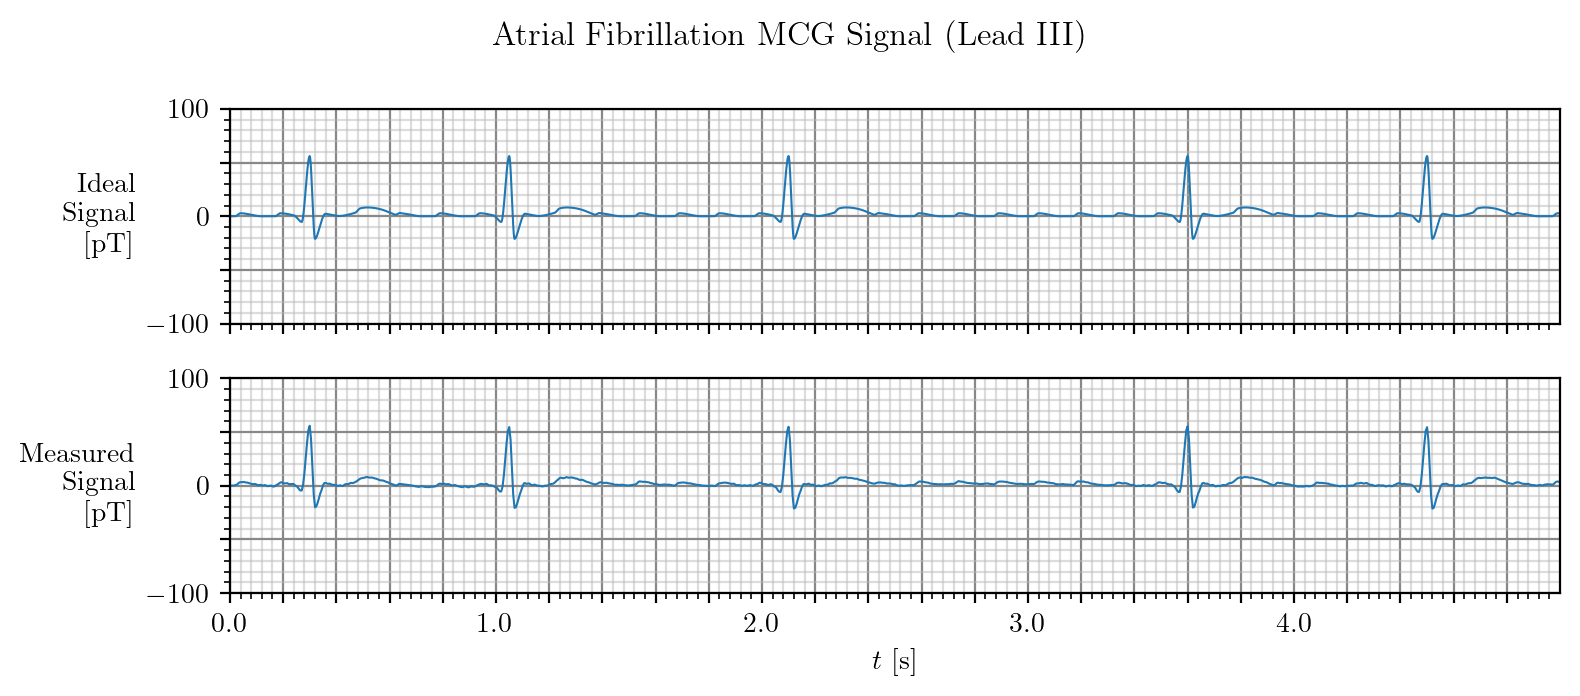

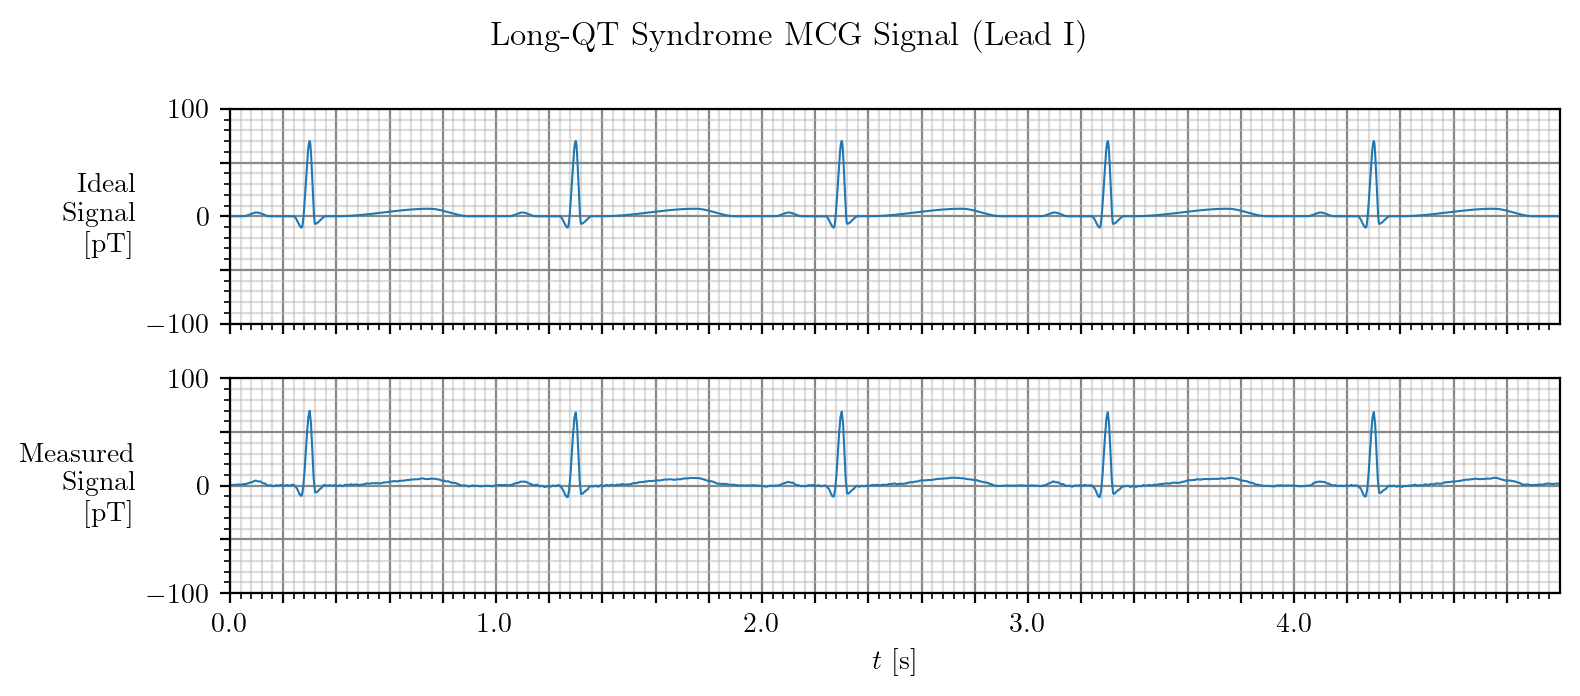

In [12]:
columns = [f"{i+1:02d}_{j}" for i in range(len(snr_desired)) for j in range(len(signals_y))]
snr_df = pd.DataFrame(columns=columns)
asc_df = pd.DataFrame(columns=columns)

snr_dict_complete = dict()
asc_dict_complete = dict()

for i, snr in enumerate(snr_desired_db):
    snr_dict, asc_dict = plot_signals(noise_y=noise_y/(10**(snr/20)), file_affix=f"_{snr}dB", file_prefix=f"{i+1:02d}_")
    snr_dict_complete = snr_dict_complete | snr_dict
    asc_dict_complete = asc_dict_complete | asc_dict

snr_df = snr_df.append(snr_dict_complete, ignore_index=True)
asc_df = asc_df.append(asc_dict_complete, ignore_index=True)

In [13]:
snr_df.to_csv(path_or_buf=data_dir+"snr.csv")
asc_df.to_csv(path_or_buf=data_dir+"asc.csv")

## Order Of Signals For Survey

In [14]:
order = [f"{i+1:02d}_{j}" for i in range(len(snr_desired)) for j in range(len(signals_y))]
random.seed(42)
random.shuffle(order)
for i, sig in enumerate(order):
    print(f"{i+1}: {sig}")

1: 02_4
2: 03_2
3: 02_0
4: 05_0
5: 07_1
6: 05_2
7: 06_4
8: 04_1
9: 06_1
10: 05_4
11: 03_4
12: 03_0
13: 03_1
14: 06_2
15: 02_3
16: 04_4
17: 07_0
18: 02_1
19: 06_0
20: 01_0
21: 07_3
22: 03_3
23: 04_3
24: 01_2
25: 07_2
26: 06_3
27: 05_1
28: 01_3
29: 05_3
30: 01_4
31: 07_4
32: 04_0
33: 04_2
34: 01_1
35: 02_2


# Figures for Paper

## Signal Examples

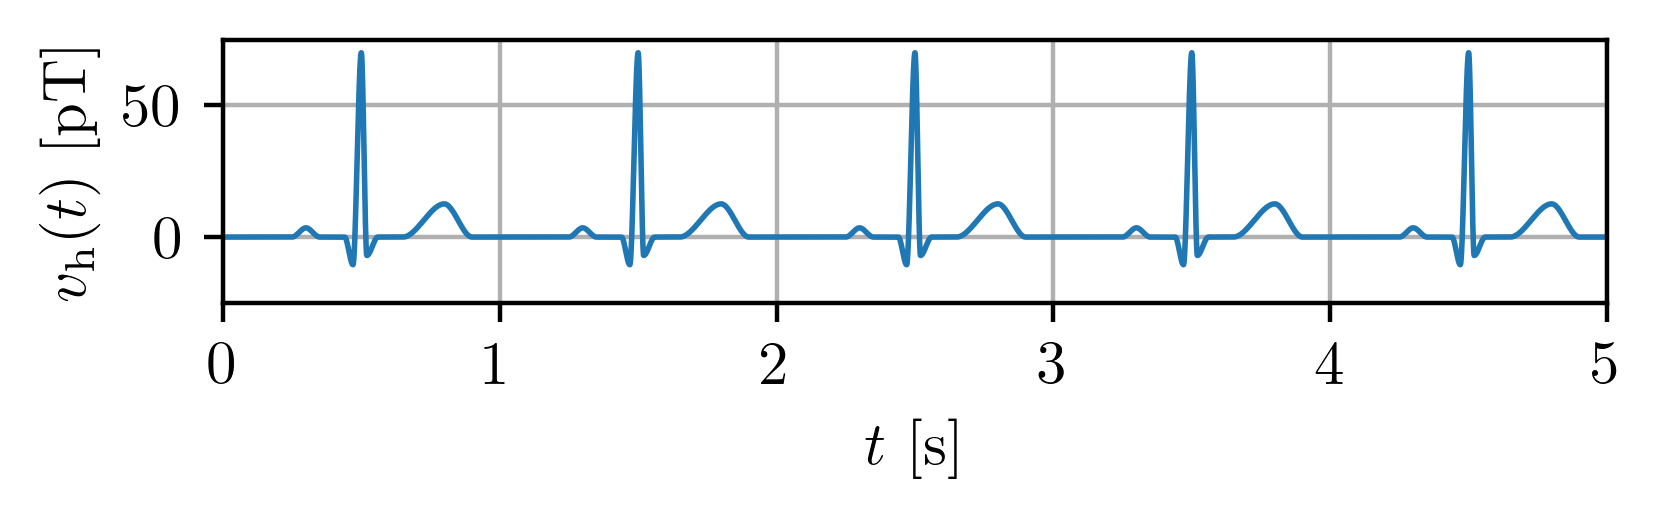

In [15]:
div = 1.4
plt.rc("figure", figsize=(6/div, 2/div), max_open_warning=0, dpi=400, autolayout=True)
plt.rc("lines", linewidth=1)
plt.rc("font", size=11)

ylim_time = [-25, 75]
xlim_time = [0, 5]

fig, ax = plt.subplots(1, 1)
ax.plot(t, mcg_y)
ax.set_ylim(ylim_time)
ax.set_xlim(xlim_time)
ax.set_ylabel("$v_{\mathrm{h}}(t)$ [pT]")
ax.set_xlabel("$t$ [s]")
fig.tight_layout()
save_fig(fig, img_dir+"/fig_mcg_healthy", save_png=save_png, save_tikz=save_tikz, save_pdf=save_pdf)

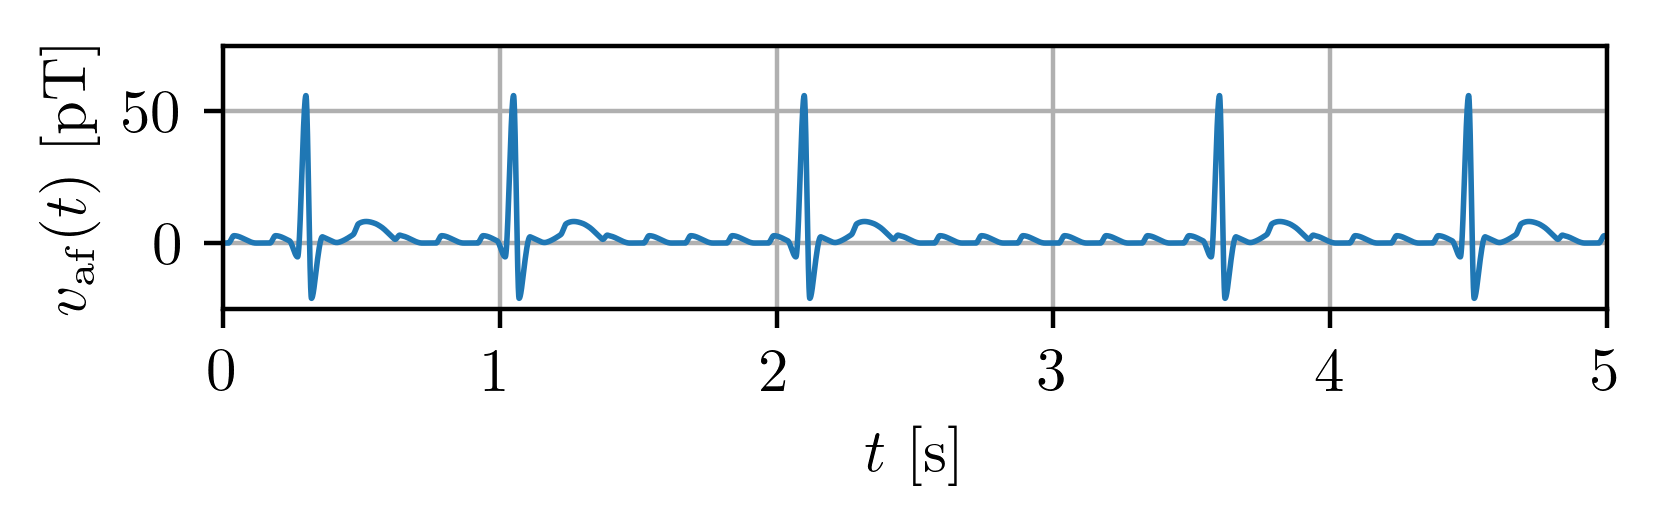

In [16]:
fig, ax = plt.subplots(1, 1)
ax.plot(t, mcg_af_y)
ax.set_ylim(ylim_time)
ax.set_xlim(xlim_time)
ax.set_ylabel("$v_{\mathrm{af}}(t)$ [pT]")
ax.set_xlabel("$t$ [s]")
fig.tight_layout()
save_fig(fig, img_dir+"/fig_mcg_af", save_png=save_png, save_tikz=save_tikz, save_pdf=save_pdf)

## Noise

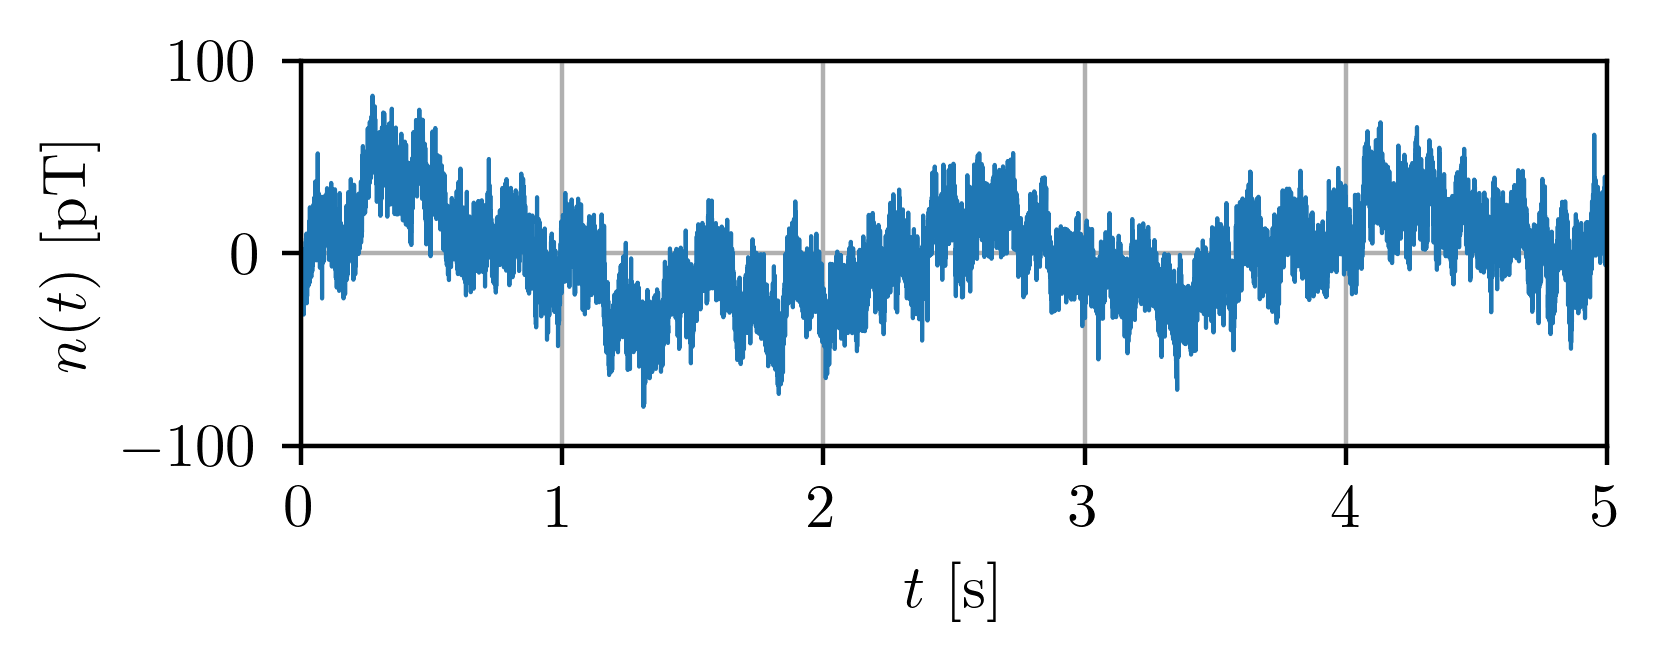

In [17]:
div = 1.4
plt.rc("figure", figsize=(6/div, 2.5/div), max_open_warning=0, dpi=400, autolayout=True)
plt.rc("lines", linewidth=0.75)
plt.rc("font", size=11)

ylim_time = [-100, 100]
fig, ax = plt.subplots(1, 1)
ax.plot(t, noise_y)
ax.set_ylim(ylim_time)
ax.set_xlim(xlim_time)
ax.set_ylabel("$n(t)$ [pT]")
ax.set_xlabel("$t$ [s]")
fig.tight_layout()
save_fig(fig, img_dir+"/fig_noise_time", save_png=save_png, save_tikz=save_tikz, save_pdf=save_pdf)

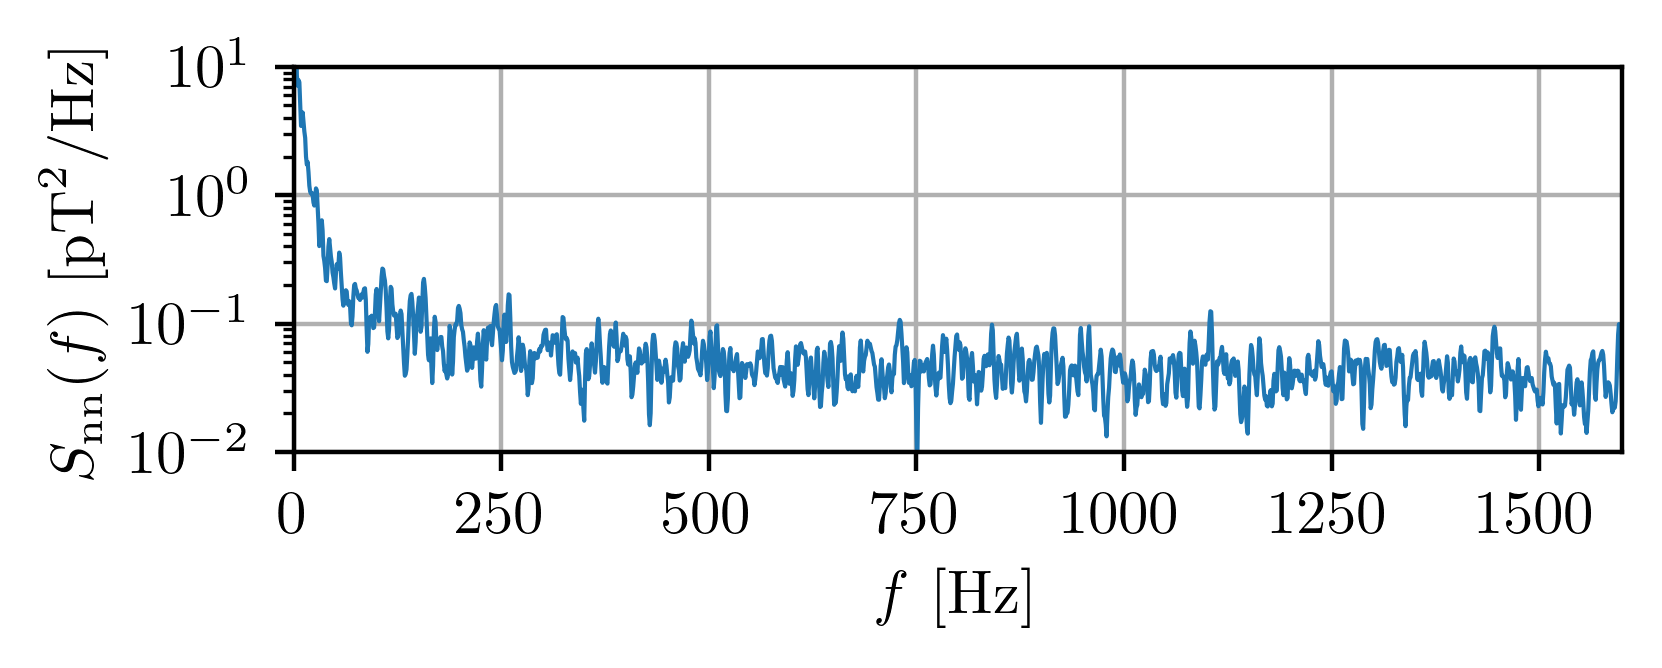

In [18]:
fig, ax = plt.subplots(1, 1)
ax.semilogy(f, noise_Syy)
ax.set_ylim(10**-2, 10**1)
ax.set_xlim([0, 1600])
ax.set_ylabel("$S_{\mathrm{nn}}(f)$ [$\mathrm{pT}^2$/Hz]")
ax.set_xlabel("$f$ [Hz]")
fig.tight_layout()
save_fig(fig, img_dir+"/fig_noise_psd", save_png=save_png, save_tikz=save_tikz, save_pdf=save_pdf)